## CamieTaggerV2:

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
import torchvision.transforms as T
import timm
from timm.models.vision_transformer import resize_pos_embed

import time
import json
import threading
import traceback
import base64
import io
from flask import Flask, render_template, render_template_string
from flask_socketio import SocketIO

import os
import pandas as pd
from pathlib import Path
import time

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import Counter, deque, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import torch._dynamo
torch.backends.cudnn.benchmark = True

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Using device: cuda


## Config:

In [2]:
class Config:  
    # Model Architecture
    backbone = 'vit_base_patch16_384'
    img_size = 512  # Configurable image size
    
    # Training with Gradient Accumulation and IRFS
    batch_size = 16                # Actual batch size per GPU
    accumulation_steps = 2         
    use_gradient_checkpointing = True  # Enable checkpointing
    epochs = 3
    learning_rate = 5e-5
    backbone_mult = 3
    weight_decay = 0.05
    
    warmup_epochs = 0.01
    debug_steps = 100
    save_steps = 10000


    # IRFS
    use_irfs = True
    repeat_thresh = 0.001
    max_repeat_factor = 3
    
    # System
    num_workers = os.cpu_count()
    prefetch_factor = 4
    pin_memory = False
    save_checkpoint = True
    checkpoint_dir = './monitor tests'

config = Config()
Path(config.checkpoint_dir).mkdir(exist_ok=True)

## Utils:

In [3]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MovingAverage:
    """Simple moving average calculator"""
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.values = []
        
    def update(self, value):
        self.values.append(value)
        if len(self.values) > self.window_size:
            self.values.pop(0)
    
    def avg(self):
        return sum(self.values) / len(self.values) if self.values else 0.0

def convert_to_wsl_path(windows_path):
    if pd.isna(windows_path):
        return windows_path
    wsl_path = windows_path.replace('\\', '/')
    if wsl_path.startswith('C:'):
        wsl_path = '/mnt/c' + wsl_path[2:]
    return wsl_path

def create_target_only_getter(dataset):
    """
    Create a function that gets targets from DataFrame without loading images
    
    This is much faster than dataset[idx] which loads and processes images
    """
    df = dataset.df
    tag_to_idx = dataset.tag_to_idx
    include_categories = dataset.include_categories
    keep_year = dataset.keep_year
    keep_rating = dataset.keep_rating
    total_tags = dataset.total_tags
    
    def get_targets_only(idx):
        """Get targets for index without loading image"""
        row = df.iloc[idx]
        targets = np.zeros(total_tags, dtype=np.float32)
        
        # Process main tag categories
        for col in include_categories:
            tag_string = row[col] if pd.notna(row[col]) else ''
            if tag_string:
                for tag in tag_string.split():
                    tag_idx = tag_to_idx.get(tag)
                    if tag_idx is not None:
                        targets[tag_idx] = 1.0
        
        # Process year tags
        if keep_year and 'created_at' in row:
            try:
                y = pd.to_datetime(row['created_at']).year
                tag_idx = tag_to_idx.get(f"year_{y}")
                if tag_idx is not None:
                    targets[tag_idx] = 1.0
            except:
                pass
        
        # Process rating tags
        if keep_rating and 'rating' in row:
            mapped = dataset.RATING_MAPPING.get(row.get('rating'))
            if mapped:
                tag_idx = tag_to_idx.get(f"rating_{mapped}")
                if tag_idx is not None:
                    targets[tag_idx] = 1.0
        
        return torch.from_numpy(targets)
    
    return get_targets_only

def compute_and_cache_tag_stats_fast(dataset, indices=None, cache_path='tag_stats.npz', force_recompute=False):
    """
    FIXED: Fast tag statistics computation without loading images
    
    Uses DataFrame directly instead of dataset[idx] which loads images
    """
    if not force_recompute and os.path.exists(cache_path):
        print(f"📁 Loading cached tag stats from {cache_path}")
        stats = np.load(cache_path)
        return {
            'class_counts': stats['class_counts'],
            'image_counts': stats['image_counts'], 
            'total_images': int(stats['total_images']),
            'total_instances': int(stats['total_instances']),
            'class_frequencies': stats['class_frequencies'],
            'image_frequencies': stats['image_frequencies']
        }
    
    print(f"⚡ Computing tag statistics (fast, no image loading) on {len(dataset)} samples...")
    
    # Create fast target getter
    get_targets_only = create_target_only_getter(dataset)
    
    class_counts = np.zeros(dataset.total_tags, dtype=np.int64)  # Instance counts
    image_counts = np.zeros(dataset.total_tags, dtype=np.int64)  # Image counts
    total_images = len(dataset)
    total_instances = 0

    idx_iter = indices if indices is not None else range(len(dataset))
    
    for idx in tqdm(idx_iter):
        targets = get_targets_only(idx)
        active_tags = torch.nonzero(targets).flatten().numpy()
        
        # Count instances (each occurrence)
        for tag_idx in active_tags:
            class_counts[tag_idx] += 1
            total_instances += 1
        
        # Count images (binary: does this image contain the tag?)
        unique_tags = np.unique(active_tags)
        for tag_idx in unique_tags:
            image_counts[tag_idx] += 1
    
    # Compute frequencies
    class_frequencies = class_counts / max(total_instances, 1)  # Avoid division by zero
    image_frequencies = image_counts / total_images
    
    # Cache results
    print(f"💾 Caching tag stats to {cache_path}")
    np.savez(cache_path, 
             class_counts=class_counts,
             image_counts=image_counts,
             total_images=total_images,
             total_instances=total_instances,
             class_frequencies=class_frequencies,
             image_frequencies=image_frequencies)
    
    print(f"✅ Tag stats computed: {total_instances:,} instances across {total_images:,} images")
    
    return {
        'class_counts': class_counts,
        'image_counts': image_counts,
        'total_images': total_images,
        'total_instances': total_instances,
        'class_frequencies': class_frequencies,
        'image_frequencies': image_frequencies
    }

## Model:

In [4]:
class ViTWrapper(nn.Module):
    """Wrapper to make ViT compatible with feature extraction for ImageTagger"""
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model
        self.out_indices = (-1,)  # mimic timm.features_only
        
        # Get patch size and embedding dim from the model
        self.patch_size = vit_model.patch_embed.patch_size[0]
        self.embed_dim = vit_model.embed_dim
        
    def forward(self, x):
        B = x.size(0)

        # ➊ patch tokens
        x = self.vit.patch_embed(x)                       # (B, N, C)

        # ➋ prepend CLS
        cls_tok = self.vit.cls_token.expand(B, -1, -1)    # (B, 1, C)
        x = torch.cat((cls_tok, x), dim=1)                # (B, 1+N, C)

        # ➌ add positional encodings (full, incl. CLS)
        if self.vit.pos_embed is not None:
            x = x + self.vit.pos_embed[:, : x.size(1), :]

        x = self.vit.pos_drop(x)

        for blk in self.vit.blocks:
            x = blk(x)

        x = self.vit.norm(x)                              # (B, 1+N, C)

        # ➍ split back out
        cls_final   = x[:, 0]              # (B, C)
        patch_tokens = x[:, 1:]            # (B, N, C)

        # ➎ reshape patches to (B, C, H, W)
        B, N, C = patch_tokens.shape
        h = w = int(N ** 0.5)              # square assumption
        patch_features = patch_tokens.permute(0, 2, 1).reshape(B, C, h, w)

        # Return **both**: (patch map, CLS)
        return patch_features, cls_final
    
    def set_grad_checkpointing(self, enable=True):
        """Enable gradient checkpointing if supported"""
        if hasattr(self.vit, 'set_grad_checkpointing'):
            self.vit.set_grad_checkpointing(enable)
            return True
        return False

class ImageTagger(nn.Module):
    """
    ImageTagger with Vision Transformer backbone
    """
    def __init__(self, total_tags, dataset, model_name='vit_base_patch16_224', 
                 num_heads=16, dropout=0.1, pretrained=True, tag_context_size=256,
                 use_gradient_checkpointing=False, img_size=224):
        super().__init__()
        
        # Store checkpointing config
        self.use_gradient_checkpointing = use_gradient_checkpointing
        self.model_name = model_name
        self.img_size = img_size
        
        # Debug and stats flags
        self._flags = {
            'debug': False,
            'model_stats': True
        }
        
        # Core model config
        self.dataset = dataset
        self.tag_context_size = tag_context_size
        self.total_tags = total_tags
        
        print(f"🏗️ Building ImageTagger with ViT backbone and {total_tags} tags")
        print(f"   Backbone: {model_name}")
        print(f"   Image size: {img_size}x{img_size}")
        print(f"   Tag context size: {tag_context_size}")
        print(f"   Gradient checkpointing: {use_gradient_checkpointing}")
        print(f"   🎯 Custom embeddings, PyTorch native attention, no ground truth inclusion")
        
        # 1. Vision Transformer Backbone
        print("📦 Loading Vision Transformer backbone...")
        self._load_vit_backbone()
        
        # Get backbone dimensions by running a test forward pass
        self._determine_backbone_dimensions()
        
        self.embedding_dim = self.backbone.embed_dim

        # 2. Custom Tag Embeddings (no CLIP)
        print("🎯 Using custom tag embeddings (no CLIP)")
        self.tag_embedding = nn.Embedding(total_tags, self.embedding_dim)
        
        # 3. Shared weights approach - tag bias for initial predictions
        print("🔗 Using shared weights between initial head and tag embeddings")
        self.tag_bias = nn.Parameter(torch.zeros(total_tags))

     
        # 4. Image token extraction (for attention AND global pooling)
        self.image_token_proj = nn.Identity()
        
        # 5. Tags-as-queries cross-attention (using PyTorch's optimized implementation)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=self.embedding_dim, 
            num_heads=num_heads, 
            dropout=dropout,
            batch_first=True  # Use (batch, seq, feature) format
        )
        self.cross_norm = nn.LayerNorm(self.embedding_dim)
        
        # Initialize weights
        self._init_weights()
        
        # Enable gradient checkpointing
        if self.use_gradient_checkpointing:
            self._enable_gradient_checkpointing()
        
        print(f"✅ ImageTagger with ViT initialized!")
        self._print_parameter_count()
    
    def _load_vit_backbone(self):
        """Load Vision Transformer model from timm"""
        print(f"   Loading from timm: {self.model_name}")
        
        # Load the ViT model (not features_only, we want the full model for token extraction)
        vit_model = timm.create_model(
            self.model_name, 
            pretrained=True,
            img_size=self.img_size,
            num_classes=0  # Remove classification head
        )
        
        # Wrap it in our compatibility layer
        self.backbone = ViTWrapper(vit_model)
        
        print(f"   ✅ ViT loaded successfully")
        print(f"   Patch size: {self.backbone.patch_size}x{self.backbone.patch_size}")
        print(f"   Embed dim: {self.backbone.embed_dim}")
    
    def _determine_backbone_dimensions(self):
        """Determine backbone output dimensions"""
        print("   🔍 Determining backbone dimensions...")
        
        with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
            # Create a dummy input 
            dummy_input = torch.randn(1, 3, self.img_size, self.img_size)
            
            # Get features
            backbone_features, cls_dummy = self.backbone(dummy_input)
            feature_tensor = backbone_features
            
            self.backbone_dim = feature_tensor.shape[1]
            self.feature_map_size = feature_tensor.shape[2]
            
        print(f"   Backbone output: {self.backbone_dim}D, {self.feature_map_size}x{self.feature_map_size} spatial")
        print(f"   Total patch tokens: {self.feature_map_size * self.feature_map_size}")
    
    def _enable_gradient_checkpointing(self):
        """Enable gradient checkpointing for memory efficiency"""
        print("🔄 Enabling gradient checkpointing...")
        
        # Enable checkpointing for ViT backbone
        if self.backbone.set_grad_checkpointing(True):
            print("   ✅ ViT backbone checkpointing enabled")
        else:
            print("   ⚠️ ViT backbone doesn't support built-in checkpointing, will checkpoint manually")
    
    def _checkpoint_backbone(self, x):
        """Wrapper for backbone with gradient checkpointing"""
        if self.use_gradient_checkpointing and self.training:
            return checkpoint.checkpoint(self.backbone, x, use_reentrant=False)
        else:
            return self.backbone(x)
    
    def _checkpoint_image_proj(self, x):
        """Wrapper for image projection with gradient checkpointing"""
        if self.use_gradient_checkpointing and self.training:
            return checkpoint.checkpoint(self.image_token_proj, x, use_reentrant=False)
        else:
            return self.image_token_proj(x)
    
    def _checkpoint_cross_attention(self, query, key, value):
        """Wrapper for cross attention with gradient checkpointing"""
        def _attention_forward(q, k, v):
            attended_features, _ = self.cross_attention(query=q, key=k, value=v)
            return self.cross_norm(attended_features)
        
        if self.use_gradient_checkpointing and self.training:
            return checkpoint.checkpoint(_attention_forward, query, key, value, use_reentrant=False)
        else:
            return _attention_forward(query, key, value)
    
    def _checkpoint_candidate_selection(self, initial_logits):
        """Wrapper for candidate selection with gradient checkpointing"""
        def _candidate_forward(logits):
            return self._get_candidate_tags(logits)
        
        if self.use_gradient_checkpointing and self.training:
            return checkpoint.checkpoint(_candidate_forward, initial_logits, use_reentrant=False)
        else:
            return _candidate_forward(initial_logits)
    
    def _checkpoint_final_scoring(self, attended_features, candidate_indices):
        """Wrapper for final scoring with gradient checkpointing"""
        def _scoring_forward(features, indices):
            emb = self.tag_embedding(indices)
            # BF16 in, BF16 out
            return (features * emb).sum(dim=-1)
        
        if self.use_gradient_checkpointing and self.training:
            return checkpoint.checkpoint(_scoring_forward, attended_features, candidate_indices, use_reentrant=False)
        else:
            return _scoring_forward(attended_features, candidate_indices)
   
    def _init_weights(self):
        """Initialize weights for new modules"""
        def _init_layer(layer):
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Embedding):
                nn.init.normal_(layer.weight, mean=0, std=0.02)
        
        # Initialize new components
        self.image_token_proj.apply(_init_layer)
        
        # Initialize tag embeddings with normal distribution
        nn.init.normal_(self.tag_embedding.weight, mean=0, std=0.02)
        
        # Initialize tag bias
        nn.init.zeros_(self.tag_bias)
    
    def _print_parameter_count(self):
        """Print parameter statistics"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        backbone_params = sum(p.numel() for p in self.backbone.parameters())
        
        print(f"📊 Parameter Statistics:")
        print(f"   Total parameters: {total_params/1e6:.1f}M")
        print(f"   Trainable parameters: {trainable_params/1e6:.1f}M")
        print(f"   Frozen parameters: {(total_params-trainable_params)/1e6:.1f}M")
        print(f"   Backbone parameters: {backbone_params/1e6:.1f}M")
        
        if self.use_gradient_checkpointing:
            print(f"   🔄 Gradient checkpointing enabled for memory efficiency")
    
    @property
    def debug(self):
        return self._flags['debug']
    
    @property
    def model_stats(self):
        return self._flags['model_stats']
    
    def _get_candidate_tags(self, initial_logits, target_tags=None, hard_negatives=None):
        """Select candidate tags - no ground truth inclusion"""
        batch_size = initial_logits.size(0)
        
        # Simply select top K candidates based on initial predictions
        top_probs, top_indices = torch.topk(
            torch.sigmoid(initial_logits), 
            k=min(self.tag_context_size, self.total_tags),
            dim=1, largest=True, sorted=True
        )
        
        return top_indices
    
    def _analyze_predictions(self, predictions, tag_indices):
        """Analyze prediction patterns"""
        if not self.model_stats:
            return {}
        
        if torch._dynamo.is_compiling():
            return {}
        
        with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
            probs = torch.sigmoid(predictions)
            relevant_probs = torch.gather(probs, 1, tag_indices)
            
            return {
                'prediction_confidence': relevant_probs.mean().item(),
                'prediction_entropy': -(relevant_probs * torch.log(relevant_probs + 1e-9)).mean().item(),
                'high_confidence_ratio': (relevant_probs > 0.7).float().mean().item(),
                'above_threshold_ratio': (relevant_probs > 0.5).float().mean().item(),
            }
    
    def forward(self, x, targets=None, hard_negatives=None):
        """
        Forward pass with ViT backbone, CLS token support and gradient-checkpointing.
        All arithmetic tensors stay in the backbone’s dtype (BF16 under autocast,
        FP32 otherwise).  Anything that must mix dtypes is cast to match.
        """
        batch_size  = x.size(0)
        model_stats = {} if self.model_stats else {}

        # ------------------------------------------------------------------
        # 1. Backbone  →  patch map + CLS token
        # ------------------------------------------------------------------
        patch_map, cls_token = self._checkpoint_backbone(x)         # patch_map: [B, C, H, W]
                                                                    # cls_token: [B, C]

        # ------------------------------------------------------------------
        # 2. Tokens  →  global image vector
        # ------------------------------------------------------------------
        image_tokens_4d = self._checkpoint_image_proj(patch_map)    # [B, C, H, W]
        image_tokens    = image_tokens_4d.flatten(2).transpose(1, 2)  # [B, N, C]

        # “Dual-pool”: mean-pool patches ⊕ CLS
        global_features = 0.5 * (image_tokens.mean(dim=1, dtype=image_tokens.dtype) + cls_token)  # [B, C]

        compute_dtype = global_features.dtype                       # BF16 or FP32

        # ------------------------------------------------------------------
        # 3. Initial logits  (shared weights)
        # ------------------------------------------------------------------
        tag_weights = self.tag_embedding.weight.to(compute_dtype)   # [T, C]
        tag_bias    = self.tag_bias.to(compute_dtype)               # [T]

        initial_logits = global_features @ tag_weights.t() + tag_bias   # [B, T]
        initial_logits = initial_logits.to(compute_dtype)               # keep dtype uniform
        initial_preds  = initial_logits                                 # alias

        # ------------------------------------------------------------------
        # 4. Candidate set
        # ------------------------------------------------------------------
        candidate_indices = self._checkpoint_candidate_selection(initial_logits)  # [B, K]

        tag_embeddings   = self.tag_embedding(candidate_indices).to(compute_dtype)  # [B, K, C]

        attended_features = self._checkpoint_cross_attention(       # [B, K, C]
            tag_embeddings, image_tokens, image_tokens
        )

        # ------------------------------------------------------------------
        # 5. Score candidates  &  scatter back
        # ------------------------------------------------------------------
        candidate_logits = self._checkpoint_final_scoring(attended_features, candidate_indices)  # [B, K]

        # --- align dtypes so scatter never throws ---
        if candidate_logits.dtype != initial_logits.dtype:
            candidate_logits = candidate_logits.to(initial_logits.dtype)

        refined_logits = initial_logits.clone()
        refined_logits.scatter_(1, candidate_indices, candidate_logits)
        refined_preds = refined_logits

        # ------------------------------------------------------------------
        # 6. Optional stats
        # ------------------------------------------------------------------
        if self.model_stats and targets is not None and not torch._dynamo.is_compiling():
            model_stats['initial_prediction_stats'] = self._analyze_predictions(initial_preds,
                                                                                candidate_indices)
            model_stats['refined_prediction_stats'] = self._analyze_predictions(refined_preds,
                                                                                candidate_indices)

        return {
            'initial_predictions': initial_preds,
            'refined_predictions': refined_preds,
            'selected_candidates': candidate_indices,
            'model_stats': model_stats
        }

## Dataset Classes:

In [5]:
class UnifiedAnimeDataset(Dataset):
    """
    Unified anime dataset with flexible resizing options
    Combines HighRes and SimpleResize functionality into one clean class
    """
    
    CATEGORY_MAPPING = {
        'tag_string_general':    'general',
        'tag_string_character':  'character',
        'tag_string_copyright':  'copyright',
        'tag_string_artist':     'artist',
        'tag_string_meta':       'meta',
    }

    RATING_MAPPING = {
        'g': 'general', 's': 'sensitive', 'q': 'questionable', 'e': 'explicit'
    }

    def __init__(self, df, target_size=None, max_size=2048, 
                 include_categories=None, keep_year_tags=False, 
                 keep_rating_tags=False, min_freq=1):
        """
        Unified dataset with flexible image resizing
        
        Args:
            df: DataFrame with image paths and tags
            target_size: If provided, resize to fixed size with aspect ratio preservation
            max_size: If target_size not provided, use thumbnail resizing with this max size
            include_categories: Which tag categories to include
            keep_year_tags: Whether to include year tags
            keep_rating_tags: Whether to include rating tags  
            min_freq: Minimum frequency for tag inclusion
        """
        self.df = df
        self.target_size = target_size
        self.max_size = max_size
        self.include_categories = tuple(include_categories) if include_categories \
                                  else tuple(self.CATEGORY_MAPPING.keys())
        self.keep_year = keep_year_tags
        self.keep_rating = keep_rating_tags
        self.min_freq = int(min_freq)

        # Label dictionaries
        self.tag_to_idx = {}
        self.idx_to_tag = {}
        self.tag_to_category = {}
        self.category_to_indices = {}

        # Build unified tag index
        self._create_unified_indices()

        # Setup transforms based on resize strategy
        if target_size is not None:
            # Fixed size with aspect ratio preservation (like SimpleResizedAnimeDataset)
            self.transform = T.Compose([
                AspectRatioPreservingResize(target_size=target_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            resize_info = f"fixed {target_size}×{target_size} with aspect ratio preservation"
        else:
            # Thumbnail resizing (like HighResUnifiedAnimeDataset)
            self.transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            resize_info = f"thumbnail with max_size {max_size}"

        print(f"Unified Dataset: {len(df)} samples, {self.total_tags} tags, {resize_info}")
        print(f"Categories: {', '.join(sorted(set(self.tag_to_category.values())))}")

    def _create_unified_indices(self):
        """Build unified label space across requested columns"""
        current = 0
        tag_counts = Counter()

        # Count tags in requested columns
        for col in self.include_categories:
            for tag_str in self.df[col].dropna():
                tag_counts.update(tag_str.split())

        def _add_tag(tag, cat):
            nonlocal current
            self.tag_to_idx[tag] = current
            self.idx_to_tag[current] = tag
            self.tag_to_category[tag] = cat
            current += 1

        # Add optional year/rating tags
        if self.keep_year:
            for year in range(2005, 2025):
                _add_tag(f"year_{year}", "year")
        if self.keep_rating:
            for r in self.RATING_MAPPING.values():
                _add_tag(f"rating_{r}", "rating")

        # Add tags with min_freq filtering
        for col in self.include_categories:
            cat = self.CATEGORY_MAPPING[col]
            for tag_str in self.df[col].dropna():
                for tag in tag_str.split():
                    if tag_counts[tag] >= self.min_freq and tag not in self.tag_to_idx:
                        _add_tag(tag, cat)

        self.total_tags = current

        # Build category indices mapping
        self.category_to_indices = {cat: [] for cat in set(self.tag_to_category.values())}
        for tag, idx in self.tag_to_idx.items():
            self.category_to_indices[self.tag_to_category[tag]].append(idx)
        
        for cat, idxs in self.category_to_indices.items():
            self.category_to_indices[cat] = torch.tensor(sorted(idxs), dtype=torch.long)

    def get_indices_by_category(self, cats):
        """Return tensor of label indices for category names"""
        if isinstance(cats, str):
            cats = [cats]
        idxs = []
        for c in cats:
            if c in self.category_to_indices:
                idxs.extend(self.category_to_indices[c].tolist())
        return torch.tensor(sorted(set(idxs)), dtype=torch.long)

    def __getitem__(self, idx):
        """Get image and target labels"""
        row = self.df.iloc[idx]
        
        # Load and process image
        try:
            with Image.open(row['image_path']) as img:
                if img.mode in ('RGBA', 'P'):
                    img = img.convert('RGB')
                
                # Apply size constraints if using thumbnail mode
                if self.target_size is None and self.max_size:
                    if max(img.size) > self.max_size:
                        img.thumbnail((self.max_size, self.max_size), Image.Resampling.LANCZOS)
                
                img = self.transform(img)
        except Exception as e:
            # Fallback to zero image
            if self.target_size is not None:
                img = torch.zeros((3, self.target_size, self.target_size))
            else:
                img = torch.zeros((3, 512, 512))

        # Build target labels
        targets = torch.zeros(self.total_tags, dtype=torch.float32)

        # Process main tag categories
        for col in self.include_categories:
            tag_string = row[col] if pd.notna(row[col]) else ''
            if tag_string:
                for tag in tag_string.split():
                    idx = self.tag_to_idx.get(tag, None)
                    if idx is not None:
                        targets[idx] = 1.0

        # Process year tags
        if self.keep_year and 'created_at' in row:
            try:
                y = pd.to_datetime(row['created_at']).year
                idx = self.tag_to_idx.get(f"year_{y}", None)
                if idx is not None:
                    targets[idx] = 1.0
            except Exception:
                pass

        # Process rating tags
        if self.keep_rating and 'rating' in row:
            mapped = self.RATING_MAPPING.get(row.get('rating', None))
            if mapped:
                idx = self.tag_to_idx.get(f"rating_{mapped}", None)
                if idx is not None:
                    targets[idx] = 1.0

        return img, targets

    def __len__(self):
        return len(self.df)
            
    def get_tag_info(self, index):
        """Get tag and its category for a given index"""
        tag = self.idx_to_tag[index]
        category = self.tag_to_category[tag]
        return tag, category
    
class AspectRatioPreservingResize:
    """Resize images to target size while preserving aspect ratio using black padding"""
    
    def __init__(self, target_size=256, fill_value=0):
        self.target_size = target_size
        self.fill_value = fill_value
    
    def __call__(self, img):
        """
        Resize image to target_size x target_size while preserving aspect ratio
        
        Args:
            img: PIL Image or torch tensor
            
        Returns:
            Resized and padded image
        """
        if isinstance(img, torch.Tensor):
            return self._resize_tensor(img)
        else:
            return self._resize_pil(img)
    
    def _resize_pil(self, img):
        """Resize PIL image with aspect ratio preservation"""
        original_width, original_height = img.size
        
        # Calculate scale factor to fit within target size
        scale = min(self.target_size / original_width, self.target_size / original_height)
        
        # Calculate new dimensions
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)
        
        # Resize image
        img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Create new image with target size and black background
        new_img = Image.new('RGB', (self.target_size, self.target_size), (0, 0, 0))
        
        # Calculate padding to center the image
        left = (self.target_size - new_width) // 2
        top = (self.target_size - new_height) // 2
        
        # Paste resized image onto black background
        new_img.paste(img_resized, (left, top))
        
        return new_img
    
    def _resize_tensor(self, img):
        """Resize torch tensor with aspect ratio preservation"""
        if img.dim() == 3:
            c, h, w = img.shape
        elif img.dim() == 4:
            b, c, h, w = img.shape
            # Handle batch dimension
            return torch.stack([self._resize_tensor(img[i]) for i in range(b)])
        else:
            raise ValueError(f"Expected 3D or 4D tensor, got {img.dim()}D")
        
        # Calculate scale factor
        scale = min(self.target_size / w, self.target_size / h)
        
        # Calculate new dimensions
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        # Resize using interpolation
        img_resized = F.interpolate(
            img.unsqueeze(0), size=(new_h, new_w), 
            mode='bilinear', align_corners=False
        ).squeeze(0)
        
        # Create padded tensor
        padded = torch.full((c, self.target_size, self.target_size), 
                           self.fill_value, dtype=img.dtype, device=img.device)
        
        # Calculate padding offsets
        left = (self.target_size - new_w) // 2
        top = (self.target_size - new_h) // 2
        
        # Place resized image in center
        padded[:, top:top+new_h, left:left+new_w] = img_resized
        
        return padded

## Training Classes:

In [6]:
class LVISIRFS:
    """LVIS-style Instance Repeat Factor Sampling"""
    def __init__(self, train_subset, tag_stats, repeat_thresh=0.001, max_repeat_factor=10.0, labels_getter=None):
        self.train_subset = train_subset
        self.repeat_thresh = repeat_thresh
        self.max_repeat_factor = max_repeat_factor
        f_img = np.clip(tag_stats['image_frequencies'].astype(np.float32), 1e-12, 1.0)
        self.r_c = np.maximum(1.0, np.sqrt(repeat_thresh / f_img))
        base_ds = train_subset.dataset
        self.labels_getter = labels_getter or create_target_only_getter(base_ds)
        self.repeat_factors = self._compute_repeat_factors()
        self.weights = torch.from_numpy(self.repeat_factors.astype(np.float32))
    
    def _compute_repeat_factors(self):
        rf = np.ones(len(self.train_subset), dtype=np.float32)
        for i, orig_idx in enumerate(self.train_subset.indices):
            active = torch.nonzero(self.labels_getter(orig_idx)).flatten().cpu().numpy()
            if active.size:
                rf[i] = min(self.max_repeat_factor, float(self.r_c[active].max()))
        return rf
    
    def get_sampler(self): 
        # Match LVIS: longer epoch proportional to total RF 
        num_samples = int(np.ceil(self.repeat_factors.sum())) 
        g = torch.Generator() 
        g.manual_seed(1104729)
        return WeightedRandomSampler(self.weights, num_samples=num_samples, replacement=True, generator=g)

class AsymmetricLoss(nn.Module):
    """
    Simple Asymmetric Loss - no logit adjustment
    """
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05):
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
    
    def forward(self, logits, targets):
        # Asymmetric Loss computation
        x_sigmoid = torch.sigmoid(logits)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid
        
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
        
        pt = targets * xs_pos + (1 - targets) * xs_neg
        one_sided_gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
        focal_weight = (1 - pt).pow(one_sided_gamma)
        
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        loss = (focal_weight * bce).mean()
        
        return loss

def get_warmup_schedule(optimizer, num_warmup_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        else:
            return 1.0  # Stay at full learning rate after warmup
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    return {"images": images, "targets": targets}

def calculate_micro_f1_with_metrics(outputs, targets, threshold=0.5):
    """Calculate micro F1, precision, and recall for training - returns tuple"""
    with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
        if isinstance(outputs, dict):
            logits = outputs['refined_predictions']
        else:
            logits = outputs
           
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()
       
        # Micro metrics: aggregate all true positives, false positives, false negatives
        tp = (preds * targets).sum().item()
        fp = (preds * (1 - targets)).sum().item()
        fn = ((1 - preds) * targets).sum().item()
       
        # Calculate micro precision, recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
       
        # Return as tuple (F1, precision, recall) - all as percentages
        return f1 * 100, precision * 100, recall * 100

def calculate_validation_metrics(model, val_loader, criterion, max_samples=256):
    """
    Returns:
        tuple: (val_loss, macro_f1_seen_labels, micro_f1, micro_precision, micro_recall, samples_f1, macro_f1_all_labels, weighted_f1_seen)
    """
    model.eval()

    all_predictions, all_targets, val_losses = [], [], []
    samples_processed = 0
    print(f"🔍 Calculating validation metrics on subset (max {max_samples} samples)...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if samples_processed >= max_samples:
                break
            try:
                images = batch["images"].to(device, non_blocking=True)
                targets = batch["targets"].to(device, non_blocking=True)
                bs = images.size(0)
                # clamp to the requested cap (keeps logging honest)
                if samples_processed + bs > max_samples:
                    bs = max_samples - samples_processed
                    images = images[:bs]
                    targets = targets[:bs]
                samples_processed += bs

                with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                    outputs = model(images, targets=targets)
                    val_loss = criterion(outputs['refined_predictions'], targets)
                    predictions = torch.sigmoid(outputs['refined_predictions'])

                val_losses.append(val_loss.item())
                all_predictions.append(predictions.detach().cpu())
                all_targets.append(targets.detach().cpu())

            except Exception as e:
                print(f"⚠️ Error processing validation batch {batch_idx}: {e}")
                continue

    if not all_predictions:
        print("❌ No valid predictions collected")
        return None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    # Stack (N, C)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    avg_val_loss = float(np.mean(val_losses)) if val_losses else 0.0

    # -> numpy
    y_true = all_targets.numpy()
    y_scores = all_predictions.numpy()
    y_pred = (y_scores > 0.5).astype(int)

    try:
        # Micro (global)
        micro_f1 = f1_score(y_true, y_pred, average='micro') * 100.0
        micro_precision = precision_score(y_true, y_pred, average='micro', zero_division=0) * 100.0
        micro_recall = recall_score(y_true, y_pred, average='micro', zero_division=0) * 100.0

        # --- Better “macro” choices for multilabel ---
        # 1) Label-macro ONLY over labels that actually appear in y_true
        support = y_true.sum(axis=0)             # per-label positives
        present = support > 0
        n_present = int(present.sum())

        if n_present > 0:
            macro_f1_seen = f1_score(y_true[:, present], y_pred[:, present],
                                     average='macro', zero_division=0) * 100.0


        print("✅ Validation metrics calculated:")
        print(f"   Loss: {avg_val_loss:.6f}")
        print(f"   Micro F1: {micro_f1:.2f}%   (P: {micro_precision:.2f}%  R: {micro_recall:.2f}%)")
        print(f"   Macro F1 (seen labels): {macro_f1_seen:.2f}%   [seen labels: {n_present}]")
        print(f"   Samples processed: {samples_processed}")

        return (avg_val_loss, macro_f1_seen, micro_f1, micro_precision, micro_recall)

    except Exception as e:
        print(f"❌ Error calculating metrics: {e}")
        return avg_val_loss, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

def calculate_training_metrics(outputs, targets):
    """
    Calculate training metrics from model outputs
    
    Returns:
        dict: Contains micro_f1, precision, recall
    """
    try:
        with torch.no_grad():
            predictions = torch.sigmoid(outputs['refined_predictions'])
            pred_binary = (predictions > 0.5).float()
            
            # Convert to numpy
            y_true = targets.cpu().numpy()
            y_pred = pred_binary.cpu().numpy()
            
            # Calculate micro metrics
            micro_f1 = f1_score(y_true, y_pred, average='micro') * 100
            micro_precision = precision_score(y_true, y_pred, average='micro') * 100
            micro_recall = recall_score(y_true, y_pred, average='micro') * 100
            
            return {
                'micro_f1': micro_f1,
                'precision': micro_precision,
                'recall': micro_recall
            }
            
    except Exception as e:
        print(f"Error calculating training metrics: {e}")
        return {'micro_f1': 0.0, 'precision': 0.0, 'recall': 0.0}

def save_checkpoint_with_batch(model, optimizer, scheduler, epoch, batch_idx, total_batches, 
                              config, dataset, checkpoint_path, irfs=None, additional_info=None):
    """Save checkpoint with batch-level information"""
    
    # Safe RNG state saving
    rng_state = {
        'python': random.getstate(),
        'numpy': np.random.get_state(),
        'torch': torch.get_rng_state(),
    }
    
    # Handle CUDA RNG state safely
    if torch.cuda.is_available() and torch.cuda.device_count() > 0:
        try:
            cuda_states = torch.cuda.get_rng_state_all()
            # Convert to CPU tensors for safe serialization
            rng_state['torch_cuda'] = [state.cpu() for state in cuda_states]
            rng_state['cuda_device_count'] = torch.cuda.device_count()
        except Exception as e:
            print(f"  ⚠️ Warning: Could not save CUDA RNG state: {e}")
            rng_state['torch_cuda'] = None
    else:
        rng_state['torch_cuda'] = None
    
    checkpoint_data = {
        'epoch': epoch,
        'batch_idx': batch_idx,
        'total_batches': total_batches,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'config': config,
        'dataset_config': {
            'total_tags': dataset.total_tags,
            'tag_to_idx': dataset.tag_to_idx,
            'idx_to_tag': dataset.idx_to_tag,
            'tag_to_category': dataset.tag_to_category
        },
        'rng_state': rng_state
    }
    
    # Save IRFS state if using IRFS
    if irfs is not None:
        irfs_state = {
            'repeat_factors': irfs.repeat_factors,
            'weights': irfs.weights,
            'repeat_thresh': irfs.repeat_thresh,
            'max_repeat_factor': irfs.max_repeat_factor,
            'r_c': irfs.r_c,
            'train_subset_indices': irfs.train_subset.indices,
        }
        checkpoint_data['irfs_state'] = irfs_state
        print(f"  💾 Saved IRFS state (repeat factors: {len(irfs.repeat_factors)})")
    
    if additional_info:
        checkpoint_data.update(additional_info)
    
    torch.save(checkpoint_data, checkpoint_path)
    return checkpoint_data

def load_checkpoint_with_batch(checkpoint_path, model, optimizer=None, scheduler=None, 
                              load_optimizer=True, load_scheduler=True):
    """Load checkpoint with batch-level information"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"   ✅ Loaded model state")
    
    # Load optimizer state (optional)
    if optimizer is not None and load_optimizer and 'optimizer_state_dict' in checkpoint:
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"   ✅ Loaded optimizer state")
        except Exception as e:
            print(f"   ⚠️ Failed to load optimizer state: {e}")
    elif not load_optimizer:
        print(f"   ⏭️ Skipped loading optimizer state (load_optimizer=False)")
    
    # Load scheduler state (optional) 
    if scheduler is not None and load_scheduler and 'scheduler_state_dict' in checkpoint:
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print(f"   ✅ Loaded scheduler state")
        except Exception as e:
            print(f"   ⚠️ Failed to load scheduler state: {e}")
    elif not load_scheduler:
        print(f"   ⏭️ Skipped loading scheduler state (load_scheduler=False)")
    
    # Restore random states for reproducible resuming (with error handling)
    if 'rng_state' in checkpoint:
        rng_state = checkpoint['rng_state']
        try:
            # Restore Python random state
            if 'python' in rng_state and rng_state['python'] is not None:
                random.setstate(rng_state['python'])
                
            # Restore NumPy random state  
            if 'numpy' in rng_state and rng_state['numpy'] is not None:
                np.random.set_state(rng_state['numpy'])
                
            # Restore PyTorch random state
            if 'torch' in rng_state and rng_state['torch'] is not None:
                torch.set_rng_state(rng_state['torch'])
                
            # Restore CUDA random states (with safety checks)
            if 'torch_cuda' in rng_state and rng_state['torch_cuda'] is not None:
                if torch.cuda.is_available():
                    cuda_states = rng_state['torch_cuda']
                    saved_device_count = rng_state.get('cuda_device_count', len(cuda_states))
                    current_device_count = torch.cuda.device_count()
                    
                    if current_device_count >= saved_device_count:
                        # Move states back to GPU and set them
                        gpu_states = []
                        for i, state in enumerate(cuda_states):
                            if i < current_device_count:
                                gpu_states.append(state.cuda(i))
                        torch.cuda.set_rng_state_all(gpu_states)
                        print(f"   ✅ Restored CUDA RNG states for {len(gpu_states)} devices")
                    else:
                        print(f"   ⚠️ Warning: Saved CUDA states for {saved_device_count} devices, but only {current_device_count} available")
                else:
                    print(f"   ⚠️ Warning: CUDA states saved but CUDA not available")
                    
            print(f"   ✅ Restored RNG states")
            
        except Exception as e:
            print(f"   ⚠️ Warning: Failed to restore some RNG states: {e}")
            print(f"   🎲 Training will continue with current random states")
    
    return checkpoint

def restore_irfs_from_checkpoint(checkpoint, train_set, tag_stats, labels_getter):
    """Restore IRFS from checkpoint data"""
    if 'irfs_state' not in checkpoint:
        return None
    
    irfs_state = checkpoint['irfs_state']
    
    # Recreate IRFS object
    irfs = LVISIRFS(
        train_set, 
        tag_stats,
        repeat_thresh=irfs_state['repeat_thresh'],
        max_repeat_factor=irfs_state['max_repeat_factor'], 
        labels_getter=labels_getter
    )
    
    # Restore saved state
    irfs.repeat_factors = irfs_state['repeat_factors']
    irfs.weights = irfs_state['weights'] 
    irfs.r_c = irfs_state['r_c']
    
    # Verify indices match (safety check)
    saved_indices = irfs_state['train_subset_indices']
    current_indices = train_set.indices
    if not np.array_equal(saved_indices, current_indices):
        print(f"   ⚠️ Warning: Train subset indices don't match saved IRFS")
        print(f"      Saved: {len(saved_indices)} indices")
        print(f"      Current: {len(current_indices)} indices")
        print(f"      Will recreate IRFS from scratch")
        return None
    
    print(f"   ✅ Restored IRFS state (repeat factors: {len(irfs.repeat_factors)})")
    return irfs

def load_vit_with_resized_pos_embed(model, state_dict, pe_key='backbone.vit.pos_embed'):
    if pe_key in state_dict:
        old_pe = state_dict[pe_key]
        new_pe = resize_pos_embed(old_pe, getattr(model, pe_key.replace('.', '_')).data if False else model.backbone.vit.pos_embed)
        state_dict[pe_key] = new_pe
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print(f"Loaded with resized pos_embed. Missing: {len(missing)} Unexpected: {len(unexpected)}")
    return missing, unexpected

def prep_512_checkpoint_from_384(checkpoint_384_path, output_512_path, dataset, config):
    """
    Prepare a 512 resolution checkpoint from a 384 resolution model.
    Explicitly resizes ViT absolute positional embeddings so you keep the 384 fine-tuned signal.
    """
    print(f"🔄 Converting 384 checkpoint to 512 resolution...")
    print(f"   Input:  {checkpoint_384_path}")
    print(f"   Output: {output_512_path}")
    
    # Load the 384 checkpoint
    checkpoint_384 = torch.load(checkpoint_384_path, map_location='cpu')
    old_state = checkpoint_384['model_state_dict']  # we'll manually resize pos_embed below
    
    # Create new 512 model
    model_512 = ImageTagger(
        total_tags=dataset.total_tags,
        dataset=dataset,
        model_name=config.backbone,  # fixed timm model name
        num_heads=16,
        dropout=0.1,
        pretrained=True,             # loads pretrained weights first
        tag_context_size=256,
        img_size=config.img_size,    # 512
    )
    
    # Split state dict into backbone (needs interpolation) vs the rest
    new_state = {}
    backbone_keys, other_keys = [], []
    for key, value in old_state.items():
        if key.startswith('backbone.vit.'):
            backbone_keys.append(key)
        else:
            other_keys.append(key)
            new_state[key] = value
    
    # Load non-backbone weights first (should match as-is)
    missing, unexpected = model_512.load_state_dict(new_state, strict=False)
    print(f"   Loaded non-backbone weights: {len(other_keys)} tensors")
    
    # Extract the backbone state dict (strip the 'backbone.vit.' prefix to match timm keys)
    backbone_state = {}
    for key in backbone_keys:
        timm_key = key.replace('backbone.vit.', '')
        backbone_state[timm_key] = old_state[key]
    
    # ---- Explicit positional embedding interpolation (384 → 512) ----
    old_pos_embed_shape = None
    if 'pos_embed' in backbone_state:
        old_pos_embed = backbone_state['pos_embed']
        old_pos_embed_shape = tuple(old_pos_embed.shape)
        # Resize to match the new model's pos_embed
        new_pos_embed = resize_pos_embed(old_pos_embed, model_512.backbone.vit.pos_embed)
        backbone_state['pos_embed'] = new_pos_embed
    
    # Load backbone (with resized pos_embed if present)
    missing_backbone, unexpected_backbone = model_512.backbone.vit.load_state_dict(
        backbone_state, strict=False
    )
    print(f"   Loaded backbone weights with explicit pos_embed interpolation")
    print(f"   Missing: {len(missing_backbone)}, Unexpected: {len(unexpected_backbone)}")
    
    # Verify position embedding was interpolated
    if old_pos_embed_shape is None:
        print(f"   Position embedding: not found in checkpoint (nothing to resize)")
    else:
        new_pos_embed_shape = tuple(model_512.backbone.vit.pos_embed.shape)
        print(f"   Position embedding: {old_pos_embed_shape} -> {new_pos_embed_shape}")
    
    # Save the new 512 checkpoint
    torch.save({
        'epoch': checkpoint_384.get('epoch', 0),
        'model_state_dict': model_512.state_dict(),
        'config': config,
        'dataset_config': checkpoint_384.get('dataset_config', {
            'total_tags': dataset.total_tags,
            'tag_to_idx': dataset.tag_to_idx,
            'idx_to_tag': dataset.idx_to_tag,
            'tag_to_category': dataset.tag_to_category
        }),
        'converted_from': checkpoint_384_path,
        'original_resolution': 384,
        'new_resolution': config.img_size
    }, output_512_path)
    
    print(f"   ✅ 512 checkpoint saved: {output_512_path}")
    return model_512

class SimplifiedTrainingMonitor:
    def __init__(self, port=5000, template_name='index.html'):
        self.app = Flask(__name__)
        self.socketio = SocketIO(self.app, cors_allowed_origins="*")
        self.port = port
        self.template_name = template_name
        
        # Simplified training stats tracking
        self.training_stats = {
            'epoch': 0,
            'total_epochs': 0,
            'batch': 0,
            'total_batches': 0,
            'start_time': None,
            'batch_start_time': None,
            'iteration_times': [],
            'current_metrics': {
                'loss': 0.0,
                'micro_f1': 0.0,
                'val_loss': 0.0
            },
            'prediction_history': []
        }
        
        @self.app.route('/')
        def index():
            # Flask automatically looks in templates/ directory
            return render_template(self.template_name)
        
        @self.socketio.on('connect')
        def handle_connect():
            pass

    def update_batch(self, batch_idx, loss, micro_f1, prec, recall, val_loss=None):
        """Update batch progress with current metrics"""
        current_time = time.time()
        
        # Update iteration timing
        if self.training_stats['batch_start_time'] is not None:
            iter_time = current_time - self.training_stats['batch_start_time']
            self.training_stats['iteration_times'].append(iter_time)
            if len(self.training_stats['iteration_times']) > 50:
                self.training_stats['iteration_times'].pop(0)
        
        self.training_stats['batch_start_time'] = current_time
        self.training_stats['batch'] = batch_idx + 1  # +1 for display purposes
        
        # Update current metrics
        self.training_stats['current_metrics'].update({
            'loss': float(loss),
            'micro_f1': float(micro_f1),
            'precision': float(prec),
            'recall': float(recall),
            'val_loss': float(val_loss) if val_loss is not None else 0.0
        })
        
        # Emit progress update
        self.emit_progress_update()

    def update_epoch_metrics(self, train_loss, train_micro_f1,
                           val_loss=None, val_micro_f1=None, val_macro_f1=None, val_precision=None, val_recall=None):
        """Update epoch-level metrics for charting"""
        try:
            metrics_update = {
                'metrics': {
                    'train': {
                        'loss': float(train_loss),
                        'micro_f1': float(train_micro_f1),
                    },
                    'val': {
                        'loss': float(val_loss) if val_loss is not None else None,
                        'micro_f1': float(val_micro_f1) if val_micro_f1 is not None else None,
                        'macro_f1': float(val_macro_f1) if val_macro_f1 is not None else None,
                        'precision': float(val_precision) if val_precision is not None else None,
                        'recall': float(val_recall) if val_recall is not None else None
                    }
                }
            }
            
            self.socketio.emit('metrics_update', json.dumps(metrics_update))
        except Exception as e:
            print(f"Error updating epoch metrics: {str(e)}")
            traceback.print_exc()

    def start(self):
        def run_server():
            self.socketio.run(self.app, port=self.port, debug=False, allow_unsafe_werkzeug=True)
            
        self.server_thread = threading.Thread(target=run_server)
        self.server_thread.daemon = True
        self.server_thread.start()
        print(f"Training monitor started at http://localhost:{self.port}")

    def start_epoch(self, epoch, total_epochs, total_batches):
        """Initialize epoch tracking"""
        self.training_stats.update({
            'epoch': epoch,
            'total_epochs': total_epochs,
            'total_batches': total_batches,
            'start_time': time.time() if self.training_stats['start_time'] is None else self.training_stats['start_time'],
            'batch': 0
        })
        self.emit_progress_update()

    def update_predictions(self, image_tensor, predictions, targets, dataset=None):
        """Update with prediction analysis data"""
        try:
            # Convert image tensor to base64
            if image_tensor is not None:
                # Denormalize and convert to PIL
                if len(image_tensor.shape) == 4:
                    image_tensor = image_tensor[0]  # Take first from batch
                
                # Convert from tensor to numpy
                if hasattr(image_tensor, 'cpu'):
                    image_np = image_tensor.cpu().detach().numpy()
                else:
                    image_np = image_tensor
                
                # Handle different tensor formats
                if image_np.shape[0] == 3:  # CHW format
                    image_np = image_np.transpose(1, 2, 0)  # Convert to HWC
                
                # Denormalize ImageNet normalization
                # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = (image_np * std) + mean  # Reverse normalization
                image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)  # Convert to 0-255
                
                # Convert to PIL and then base64
                image_pil = Image.fromarray(image_np)
                buffer = io.BytesIO()
                image_pil.save(buffer, format='JPEG')
                image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
                image_data = f'data:image/jpeg;base64,{image_base64}'
            else:
                image_data = ''

            # Analyze predictions vs ground truth
            if hasattr(predictions, 'cpu'):
                pred_probs = predictions.cpu().detach().numpy()
            else:
                pred_probs = predictions
            
            if hasattr(targets, 'cpu'):
                true_labels = targets.cpu().detach().numpy()
            else:
                true_labels = targets

            # Take first sample if batch
            if len(pred_probs.shape) > 1 and pred_probs.shape[0] > 1:
                pred_probs = pred_probs[0]
                true_labels = true_labels[0]

            # Ensure we have 1D arrays
            pred_probs = pred_probs.flatten()
            true_labels = true_labels.flatten()

            # Apply sigmoid if needed
            if pred_probs.max() > 1 or pred_probs.min() < 0:
                pred_probs = 1 / (1 + np.exp(-pred_probs))  # sigmoid

            # Create binary predictions (using 0.5 threshold)
            pred_binary = pred_probs > 0.5

            # Get all unique categories if dataset available
            categories_set = set()
            if dataset and hasattr(dataset, 'tag_to_category'):
                categories_set = set(dataset.tag_to_category.values())

            # Analyze by categories if dataset provided
            category_predictions = {}
            if dataset and hasattr(dataset, 'idx_to_tag') and hasattr(dataset, 'tag_to_category'):
                for category in categories_set:
                    correct = []
                    incorrect = []
                    missing = []
                    
                    for idx in range(len(pred_probs)):
                        if idx in dataset.idx_to_tag:
                            tag = dataset.idx_to_tag[idx]
                            tag_category = dataset.tag_to_category[tag]
                            
                            if tag_category == category:
                                prob_val = float(pred_probs[idx].item() if hasattr(pred_probs[idx], 'item') else pred_probs[idx])
                                is_pred = bool(pred_binary[idx])
                                is_true = bool(true_labels[idx] > 0.5)
                                
                                if is_true and is_pred:
                                    correct.append({'tag': tag, 'probability': prob_val})
                                elif not is_true and is_pred:
                                    incorrect.append({'tag': tag, 'probability': prob_val})
                                elif is_true and not is_pred:
                                    missing.append({'tag': tag, 'probability': prob_val})
                    
                    if correct or incorrect or missing:  # Only add if category has tags
                        category_predictions[category] = {
                            'correct': correct,
                            'incorrect': incorrect,
                            'missing': missing
                        }
            else:
                # Fallback to simple analysis without categories
                category_predictions = {'All Tags': {
                    'correct': [],
                    'incorrect': [], 
                    'missing': []
                }}

            # Create tag info for selection analysis
            tag_info = []
            selected_indices = np.where(pred_binary)[0]
            total_ground_truth = int(np.sum(true_labels > 0.5))
            
            for idx in selected_indices:
                prob_val = float(pred_probs[idx].item() if hasattr(pred_probs[idx], 'item') else pred_probs[idx])
                
                # Get real tag name and category if available
                if dataset and hasattr(dataset, 'idx_to_tag') and idx in dataset.idx_to_tag:
                    tag_name = dataset.idx_to_tag[idx]
                    tag_category = dataset.tag_to_category.get(tag_name, 'Unknown')
                else:
                    tag_name = f'Tag_{idx}'
                    tag_category = 'Unknown'
                
                tag_info.append({
                    'tag_name': tag_name,
                    'category': tag_category,
                    'probability': prob_val,
                    'is_ground_truth': bool(true_labels[idx] > 0.5)
                })

            # Prepare prediction update
            prediction_update = {
                'predictions': {
                    'image': image_data,
                    'category_predictions': category_predictions,
                    'tag_info': tag_info,
                    'tag_selection': {
                        'total_ground_truth': total_ground_truth
                    }
                }
            }

            # Store in history
            self.training_stats['prediction_history'].append(prediction_update['predictions'])
            if len(self.training_stats['prediction_history']) > 100:
                self.training_stats['prediction_history'].pop(0)

            # Emit update
            self.socketio.emit('metrics_update', json.dumps(prediction_update))

        except Exception as e:
            print(f"Error updating predictions: {str(e)}")
            traceback.print_exc()

    def calculate_progress_metrics(self):
        """Calculate training progress metrics"""
        stats = self.training_stats
        current_time = time.time()
        
        # Calculate iteration speed
        if len(stats['iteration_times']) > 0:
            recent_times = stats['iteration_times'][-10:]
            iter_speed = len(recent_times) / sum(recent_times) if sum(recent_times) > 0 else 0
        else:
            iter_speed = 0
        
        # Calculate timing metrics
        elapsed_time = int(current_time - stats['start_time']) if stats['start_time'] else 0
        
        # Estimate remaining time
        if iter_speed > 0:
            batches_remaining = (stats['total_batches'] - stats['batch']) + \
                              (stats['total_epochs'] - stats['epoch'] - 1) * stats['total_batches']
            time_remaining = int(batches_remaining / iter_speed)
        else:
            time_remaining = 0
        
        return {
            'epoch': stats['epoch'],
            'total_epochs': stats['total_epochs'],
            'batch': stats['batch'],
            'total_batches': stats['total_batches'],
            'iter_speed': round(iter_speed, 2),
            'time_remaining': time_remaining,
            'elapsed_time': elapsed_time,
            'current_metrics': stats['current_metrics']
        }

    def emit_progress_update(self):
        """Emit current training progress"""
        try:
            progress_data = self.calculate_progress_metrics()
            self.socketio.emit('training_update', json.dumps({'progress': progress_data}))
        except Exception as e:
            print(f"Error emitting progress update: {str(e)}")
            traceback.print_exc()
    
def train_epoch(model, train_loader, val_loader, criterion, 
                optimizer, scheduler, epoch, scaler, start_batch=0, irfs=None, monitor=None):
    """
    Training loop with integrated monitoring
    """
    model.train()
    
    loss_meter = AverageMeter()
    micro_f1_meter = AverageMeter()
    prec_meter = AverageMeter()
    recall_meter = AverageMeter()
    f1_smooth = MovingAverage(window_size=50)
    prec_smooth = MovingAverage(window_size=50)
    recall_smooth = MovingAverage(window_size=50)
   
    # Gradient accumulation setup
    accumulation_steps = config.accumulation_steps
    effective_batch_size = config.batch_size * accumulation_steps
    total_batches = len(train_loader)
    
    # Initialize monitor for this epoch
    if monitor:
        monitor.start_epoch(epoch, config.epochs, total_batches)

    data_iterator = iter(train_loader)
    initial_step = 1

    pbar = tqdm(
        range(initial_step, total_batches + 1), 
        desc=f"Epoch {epoch} - ImageTagger (Effective BS: {effective_batch_size})",
        initial=start_batch,
        total=total_batches
    )

    # Initialize gradients
    optimizer.zero_grad(set_to_none=True)
    
    try:
        for step in pbar:
            try:
                batch = next(data_iterator)
            except StopIteration:
                print("⚠️ Reached end of data loader")
                break
            
            # Handle list of images from collate_fn
            images = batch["images"].to(device, non_blocking=True)
            targets = batch["targets"].to(device, non_blocking=True)
       
            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                # Forward pass
                outputs = model(images, targets=targets)
                
                # Simple loss (just classification)
                loss = criterion(outputs['refined_predictions'], targets)
                
                # Scale loss by accumulation steps for proper averaging
                scaled_loss = loss / accumulation_steps
                
                # Calculate metrics
                micro_f1, precision, recall = calculate_micro_f1_with_metrics(outputs, targets)
                f1_smooth.update(micro_f1)
                prec_smooth.update(precision)
                recall_smooth.update(recall)
            
            # Update meters
            loss_meter.update(loss.item(), images.size(0))
            micro_f1_meter.update(micro_f1, images.size(0))
            prec_meter.update(precision, images.size(0))
            recall_meter.update(recall, images.size(0))
            
            # Update monitor with current batch progress
            if monitor:
                monitor.update_batch(step - 1, loss.item(), f1_smooth.avg(), prec_smooth.avg(), recall_smooth.avg())
            
            # Backward pass with scaled loss
            scaled_loss.backward()
            
            # Step optimizer every accumulation_steps or at the end
            if step % accumulation_steps == 0 or step == total_batches:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                
                if scheduler:
                    scheduler.step()
            
            # Update progress bar
            pbar.set_postfix(
                loss=f"{loss.item():.4f}",
                μF1=f"{f1_smooth.avg():.1f}%",
                lr=f"{scheduler.get_last_lr()[0]:.6f}" if scheduler else f"{optimizer.param_groups[0]['lr']:.6f}",
                acc_step=f"{(step-1) % accumulation_steps + 1}/{accumulation_steps}"
            )
            
            # Detailed logging with monitor integration
            if step % (config.debug_steps * accumulation_steps) == 0 or step == initial_step:
                # Model statistics (if available)
                if hasattr(outputs, 'model_stats') and outputs.get('model_stats'):
                    stats = outputs['model_stats']
                    print(f"  📈 Model Stats:")
                    for key, value in stats.items():
                        if isinstance(value, dict):
                            print(f"    {key}:")
                            for sub_key, sub_value in value.items():
                                print(f"      {sub_key}: {sub_value:.4f}")
                        else:
                            if key == 'gt_inclusion_rate':
                                print(f"    GT inclusion rate: {value:.2%}")
                            elif key == 'avg_gt_tags_per_sample':
                                print(f"    Avg GT tags/sample: {value:.1f}")
                            else:
                                print(f"    {key}: {value:.4f}")
                
                # Update monitor with prediction analysis
                if monitor:
                    try:
                        # Update predictions in monitor with dataset for proper tag names
                        monitor.update_predictions(
                            image_tensor=images[0:1],  # Take first image from batch
                            predictions=outputs['refined_predictions'][0:1],  # Take first prediction
                            targets=targets[0:1],  # Take first target
                            dataset=dataset  # Pass the full dataset for tag name lookup
                        )
                    except Exception as pred_e:
                        print(f"  ⚠️ Prediction analysis failed: {pred_e}")
                
                # Enhanced validation with comprehensive metrics
                try:
                    val_loss, val_macro_f1, val_micro_f1, val_precision, val_recall = calculate_validation_metrics(
                        model, val_loader, criterion, max_samples=256
                    )
                    
                    # Update monitor with comprehensive validation metrics
                    if monitor:
                        monitor.update_epoch_metrics(
                            train_loss=loss.item(),
                            train_micro_f1=f1_smooth.avg(),
                            val_loss=val_loss,
                            val_micro_f1=val_micro_f1,
                            val_macro_f1=val_macro_f1,
                            val_precision=val_precision,
                            val_recall=val_recall
                        )
                        
                except Exception as e:
                    print(f"  ⚠️ Validation failed: {e}")

            # Save model with batch information
            if step % (config.save_steps * accumulation_steps) == 0 or step == initial_step:
                if config.save_checkpoint:
                    checkpoint_path = f'{config.checkpoint_dir}/image_tagger_epoch{epoch}_batch{step}.pth'
                    save_checkpoint_with_batch(
                        model, optimizer, scheduler, epoch, step, total_batches, 
                        config, dataset, checkpoint_path, irfs=irfs
                    )
                    print(f"  ✅ Saved model at epoch {epoch}, batch {step}")
            
            # Memory cleanup
            if step % (100 * accumulation_steps) == 0:
                torch.cuda.empty_cache()
    
    except KeyboardInterrupt:
        print(f"\n⏹️ Training interrupted at batch {step}")
        if config.save_checkpoint:
            checkpoint_path = f'{config.checkpoint_dir}/image_tagger_epoch{epoch}_batch{step}_interrupted.pth'
            save_checkpoint_with_batch(
                model, optimizer, scheduler, epoch, step, total_batches, 
                config, dataset, checkpoint_path, irfs=irfs
            )
            print(f"💾 Saved interrupted checkpoint: {checkpoint_path}")
        raise
    
    return loss_meter.avg, micro_f1_meter.avg

def train_model(dataset, config, checkpoint_path=None, use_irfs=True, load_optimizer=True, load_scheduler=True):
    """
    Training function with integrated monitoring
    """
    
    # Initialize the training monitor
    monitor = SimplifiedTrainingMonitor(port=5000)
    monitor.start()
    
    print("="*80)
    print(f"🚀 IMAGETAGGER TRAINING - {config.img_size}x{config.img_size}")
    print("="*80)
    print("Model features:")
    print(f"• {config.backbone} backbone")
    print(f"• {config.img_size}x{config.img_size} resolution")
    print("• Tags-as-queries cross-attention")
    print("• Asymmetric Loss")
    print("• Gradient accumulation for larger effective batch size")
    print("• Batch-level checkpointing and resume")
    print("• Real-time training monitor at http://localhost:5000")
    if checkpoint_path:
        print(f"• Load optimizer: {load_optimizer}")
        print(f"• Load scheduler: {load_scheduler}")
    print()

    # Initialize the model with config parameters
    print(f"🏗️ Initializing ImageTagger at {config.img_size}x{config.img_size}...")
    model = ImageTagger(
        total_tags=dataset.total_tags,
        dataset=dataset,
        model_name=config.backbone,
        num_heads=16,
        dropout=0.1,
        pretrained=True,
        tag_context_size=256,
        img_size=config.img_size,
        use_gradient_checkpointing=config.use_gradient_checkpointing,
    ).to(device)
 
    # Create splits
    train_idx, val_idx = train_test_split(
        np.arange(len(dataset)),
        test_size=0.01, random_state=42, shuffle=True
    )

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)

    # IRFS setup (same as before)
    irfs = None
    train_sampler = None
    shuffle = True
    
    if use_irfs:           
        print("📊 Computing/loading tag statistics (fast mode)...")
        cache_path = f"tag_stats_fast_train_{config.img_size}.npz"
        tag_stats = compute_and_cache_tag_stats_fast(
            dataset, indices=train_idx, cache_path=cache_path
        )
        
        print("🎯 Building fixed IRFS...")
        labels_getter = create_target_only_getter(dataset)
        irfs = LVISIRFS(train_set, tag_stats, 
                        repeat_thresh=config.repeat_thresh, 
                        max_repeat_factor=config.max_repeat_factor, 
                        labels_getter=labels_getter)
        train_sampler = irfs.get_sampler()
        shuffle = False

        # IRFS stats
        r_i = np.asarray(irfs.repeat_factors, dtype=np.float32)
        N = len(irfs.train_subset)
        epoch_multiplier = float(r_i.sum() / N)
        p90, p95, p99 = np.percentile(r_i, [90, 95, 99])
        frac_capped = float((r_i >= irfs.max_repeat_factor - 1e-8).mean())

        print(f"[IRFS] N={N:,}  sum(r_i)={r_i.sum():,.0f}  x-mult={epoch_multiplier:.2f}x")
        print(f"[IRFS] capped@{irfs.max_repeat_factor}: {frac_capped*100:.1f}%  p90={p90:.2f}  p95={p95:.2f}  p99={p99:.2f}")

    # Create data loaders    
    train_loader = DataLoader(
        train_set,
        batch_size=config.batch_size,
        sampler=train_sampler,
        shuffle=shuffle,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=(config.num_workers > 0),
        collate_fn=collate_fn,
        prefetch_factor=config.prefetch_factor,
    )

    val_loader = DataLoader(
        val_set, 
        batch_size=config.batch_size, 
        shuffle=False,
        num_workers=2,
        pin_memory=config.pin_memory,
        collate_fn=collate_fn,
        prefetch_factor=1
    )
    
    # Training setup
    print("⚙️ Setting up training components...")
    criterion = AsymmetricLoss(gamma_pos=0, gamma_neg=4, clip=0.05).to(device)
    
    # Optimizer setup
    backbone_params = []
    head_params = []
    
    for name, param in model.named_parameters():
        if 'backbone' in name:
            backbone_params.append(param)
        else:
            head_params.append(param)
    
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': config.learning_rate, 'name': 'backbone'},
        {'params': head_params, 'lr': config.learning_rate * config.backbone_mult, 'name': 'heads'},
    ], weight_decay=config.weight_decay)
    
    # Scheduler setup
    total_steps = len(train_loader) * config.epochs // config.accumulation_steps
    warmup_steps = int(total_steps * config.warmup_epochs)
    scheduler = get_warmup_schedule(optimizer, warmup_steps)

    # Load checkpoint if provided (same as before)
    start_epoch = 1
    start_batch = 0
    
    if checkpoint_path:
        print(f"📁 Loading checkpoint: {checkpoint_path}")
        
        try:
            checkpoint = load_checkpoint_with_batch(
                checkpoint_path, model, optimizer, scheduler, 
                load_optimizer=load_optimizer, load_scheduler=load_scheduler
            )
            
            start_epoch = checkpoint.get('epoch', 1)
            start_batch = checkpoint.get('batch_idx', 0)
            total_batches_saved = checkpoint.get('total_batches', len(train_loader))
            
            print(f"   ✅ Loaded checkpoint from epoch {start_epoch}, batch {start_batch + 1}/{total_batches_saved}")
            
            # Handle IRFS restoration if we were using IRFS
            if use_irfs and irfs is not None:
                restored_irfs = restore_irfs_from_checkpoint(checkpoint, train_set, tag_stats, labels_getter)
                if restored_irfs is not None:
                    irfs = restored_irfs
                    train_sampler = irfs.get_sampler()
                    
                    train_loader = DataLoader(
                        train_set,
                        batch_size=config.batch_size,
                        sampler=train_sampler,
                        shuffle=False,
                        num_workers=config.num_workers,
                        pin_memory=config.pin_memory,
                        persistent_workers=(config.num_workers > 0),
                        collate_fn=collate_fn,
                        prefetch_factor=config.prefetch_factor,
                    )
            
            if 'original_resolution' in checkpoint:
                print(f"   ✅ Loading converted checkpoint ({checkpoint['original_resolution']} -> {checkpoint['new_resolution']})")
            
            if start_batch >= len(train_loader):
                start_epoch += 1
                start_batch = 0
                print(f"   📈 Previous epoch completed, starting epoch {start_epoch}")
                
        except Exception as e:
            print(f"   ⚠️ Error loading checkpoint: {e}")
            print("   🔄 Starting fresh training")
            start_epoch = 1
            start_batch = 0

    print(f"   Training at {config.img_size}x{config.img_size} resolution")
    print(f"   Effective batch size: {config.batch_size * config.accumulation_steps}")
    print(f"   Use IRFS: {use_irfs}")
    print(f"   Resume from: epoch {start_epoch}, batch {start_batch + 1}")
    
    # Run the actual training loop
    best_f1 = 0
    print(f"\n🎯 Starting training for {config.epochs} epochs...")
    print(f"📊 Monitor available at: http://localhost:5000")
    
    for epoch in range(start_epoch, start_epoch + config.epochs):
        print(f"\n{'='*60}")
        print(f"📚 EPOCH {epoch}/{start_epoch + config.epochs - 1}")
        print(f"{'='*60}")
        
        # Training phase - pass start_batch only for the first epoch we're resuming
        epoch_start_batch = start_batch if epoch == start_epoch else 0
        
        try:
            train_loss, train_f1 = train_epoch(
                model, train_loader, val_loader, criterion, optimizer, scheduler, 
                epoch, None, start_batch=epoch_start_batch, irfs=irfs, monitor=monitor
            )
        except KeyboardInterrupt:
            print("🛑 Training interrupted by user")
            return model, best_f1
        
        # Reset start_batch after first resumed epoch
        start_batch = 0
        
        print(f"\n📈 Epoch {epoch} Results:")
        print(f"  Loss: {train_loss:.4f}")
        print(f"  Micro F1: {train_f1:.2f}%")
        
        # Validation phase
        if epoch % 1 == 0:
            try:
                val_loss, val_macro_f1, val_micro_f1, val_precision, val_recall = calculate_validation_metrics(
                    model, val_loader, criterion, max_samples=2048
                )
                print(f"  🎯 Validation Loss: {val_loss:.6f}")
                print(f"  🎯 Validation Macro F1: {val_macro_f1:.2f}%")
                print(f"  🎯 Validation Micro F1: {val_micro_f1:.2f}%")
                print(f"  🎯 Validation Precision: {val_precision:.2f}%")
                print(f"  🎯 Validation Recall: {val_recall:.2f}%")
                
                # Update monitor with comprehensive validation metrics
                if monitor:
                    monitor.update_epoch_metrics(
                        val_loss=val_loss,
                        val_micro_f1=val_micro_f1,
                        val_macro_f1=val_macro_f1,
                        val_precision=val_precision,
                        val_recall=val_recall
                    )
                    
            except Exception as e:
                print(f"  ⚠️ Validation failed: {e}")
                current_f1 = train_f1
        else:
            current_f1 = train_f1
        
        # Save best model (epoch-level)
        if current_f1 > best_f1:
            best_f1 = current_f1
            if config.save_checkpoint:
                checkpoint_name = f'best_image_tagger_{config.img_size}x{config.img_size}.pth'
                checkpoint_path_best = f'{config.checkpoint_dir}/{checkpoint_name}'
                save_checkpoint_with_batch(
                    model, optimizer, scheduler, epoch, len(train_loader), len(train_loader), 
                    config, dataset, checkpoint_path_best, irfs=irfs,
                    additional_info={'best_f1': best_f1, 'resolution': config.img_size}
                )
                print(f"  ✅ Saved best model (F1: {best_f1:.2f}%)")
    
    print(f"\n{'='*80}")
    print(f"🎉 TRAINING COMPLETE at {config.img_size}x{config.img_size}!")
    print(f"{'='*80}")
    print(f"🏆 Best F1 Score: {best_f1:.2f}%")
    print(f"💾 Model saved with resolution info in checkpoint")
    print(f"📊 Training monitor: http://localhost:5000")
    
    return model, best_f1

## Train:

In [ ]:
# Load and setup dataset
print("Loading dataset...")
sampled_df = pd.read_csv('')
sampled_df['image_path'] = sampled_df['image_path'].apply(convert_to_wsl_path)

# Create unified dataset
include_cols = tuple(UnifiedAnimeDataset.CATEGORY_MAPPING.keys())

dataset = UnifiedAnimeDataset(
    sampled_df,
    target_size=config.img_size,                    # Fixed size with aspect ratio preservation
    include_categories=include_cols,
    keep_year_tags=True,
    keep_rating_tags=True,
    min_freq=1
)

Loading dataset...
Unified Dataset: 2011580 samples, 70527 tags, fixed 512×512 with aspect ratio preservation
Categories: artist, character, copyright, general, meta, rating, year


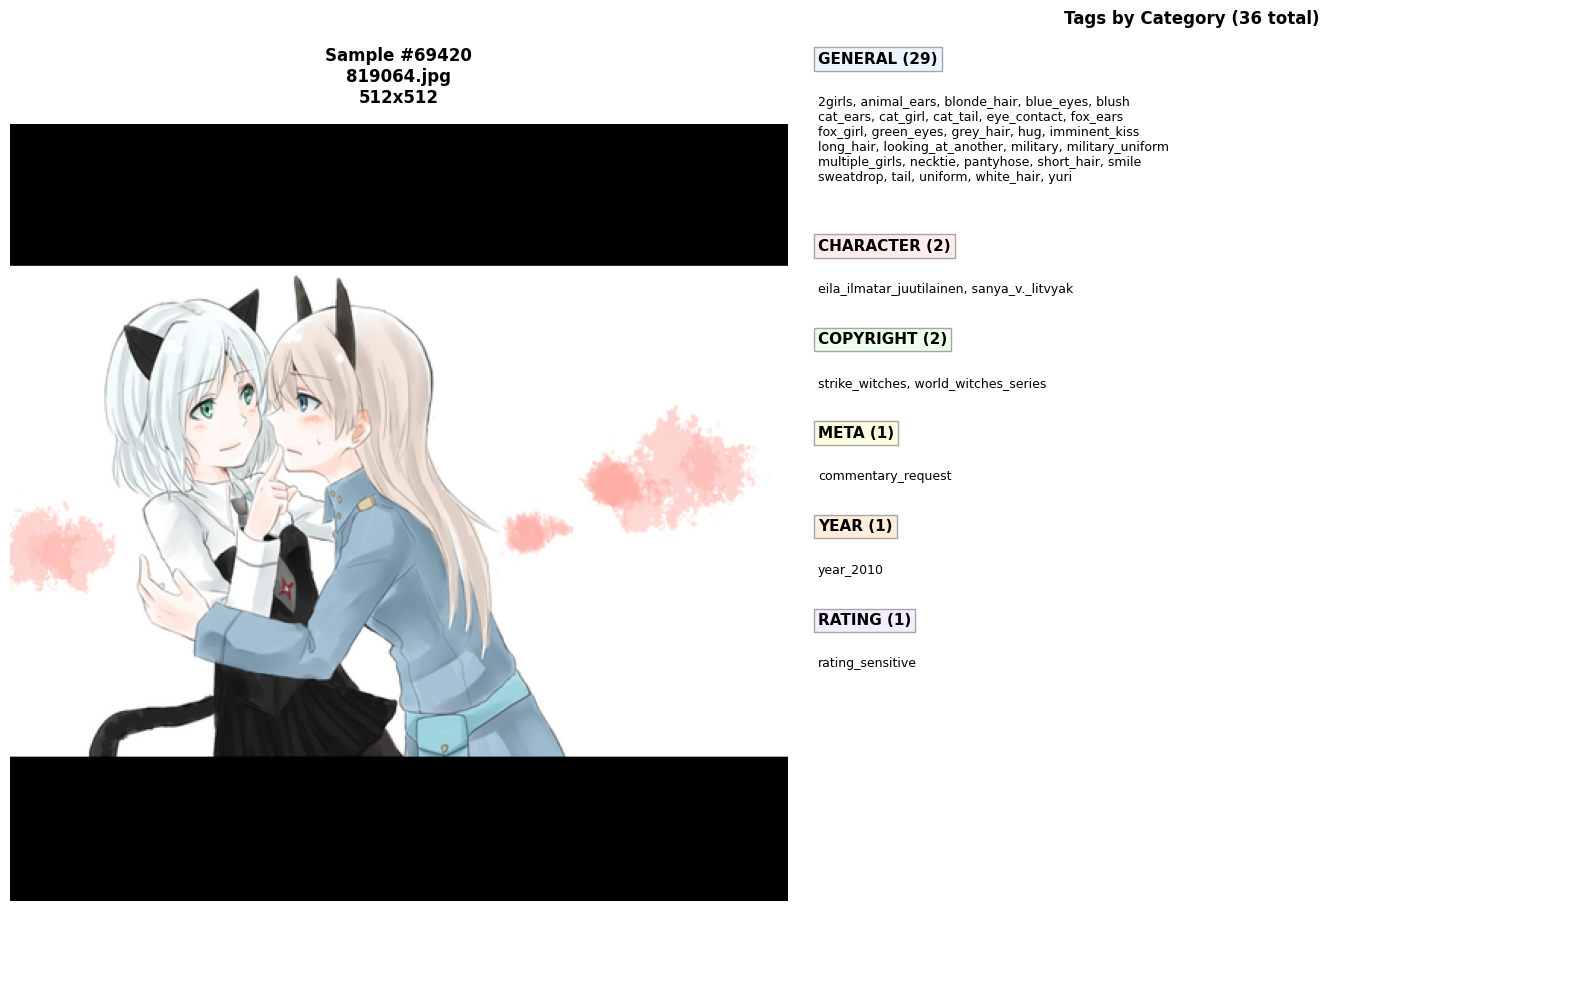


Sample 69420 details:
Image path: /mnt/c/Users/Camais/Desktop/AI/Datasets/Anime Images/Stratified Sample Dataset/819064.jpg
Total active tags: 36
general: 29 tags
character: 2 tags
copyright: 2 tags
meta: 1 tags
year: 1 tags
rating: 1 tags


In [8]:
def denormalize_imagenet(tensor):
    """
    Denormalize ImageNet normalized tensor back to [0,1] range
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Denormalize
    denormalized = tensor * std + mean
    # Clamp to [0,1] range
    denormalized = torch.clamp(denormalized, 0, 1)
    
    return denormalized

def format_tag_list(tags, max_line_length=60):
    """Format a list of tags with proper spacing and line breaks"""
    if not tags:
        return "No tags"
    
    current_line = []
    lines = []
    current_length = 0
    
    for tag in tags:
        tag_length = len(tag) + 2  # +2 for ", " spacing
        if current_length + tag_length > max_line_length and current_line:
            lines.append(', '.join(current_line))
            current_line = [tag]
            current_length = len(tag)
        else:
            current_line.append(tag)
            current_length += tag_length
    
    if current_line:
        lines.append(', '.join(current_line))
    
    return '\n'.join(lines)

def visualize_sample(dataset, idx=0, figsize=(16, 10)):
    """
    Visualize an image and its associated tags from the unified dataset.
    
    Args:
        dataset: UnifiedAnimeDataset instance
        idx: Index of sample to visualize
        figsize: Figure size tuple (width, height)
    """
    # Validate index
    if idx >= len(dataset):
        raise IndexError(f"Index {idx} is out of range for dataset of size {len(dataset)}")
    
    # Get the sample
    img, tag_targets = dataset[idx]
    
    # Get the original row for additional info
    row = dataset.df.iloc[idx]
    
    # Denormalize and convert image tensor to numpy for plotting
    img_denorm = denormalize_imagenet(img)
    img_np = img_denorm.permute(1, 2, 0).numpy()  # Convert to HWC format
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot image
    ax1.imshow(img_np)
    ax1.axis('off')
    
    # Get image info for title
    img_path = row.get('image_path', 'Unknown')
    img_filename = img_path.split('/')[-1] if '/' in img_path else img_path
    img_size = f"{img.shape[2]}x{img.shape[1]}"  # W x H
    ax1.set_title(f'Sample #{idx}\n{img_filename}\n{img_size}', 
                  fontsize=12, fontweight='bold', pad=15)
    
    # Plot tags
    ax2.axis('off')
    
    # Category colors for visual separation
    category_colors = {
        'general': '#E6F3FF',      # Light blue
        'character': '#FFE6E6',    # Light red  
        'copyright': '#E6FFE6',    # Light green
        'artist': '#FFE6FF',       # Light purple
        'meta': '#FFFFD9',         # Light yellow
        'year': '#FFE6CC',         # Light orange
        'rating': '#F0E6FF',       # Light lavender
    }
    
    # Get active tags and organize by category
    active_indices = torch.where(tag_targets == 1)[0]
    tags_by_category = defaultdict(list)
    
    for idx_val in active_indices:
        tag, category = dataset.get_tag_info(idx_val.item())
        tags_by_category[category].append(tag)
    
    # Count total tags
    total_tags = len(active_indices)
    ax2.set_title(f'Tags by Category ({total_tags} total)', 
                  fontsize=12, fontweight='bold', pad=15)
    
    y_position = 0.98  # Start position
    base_line_height = 0.08  # Base spacing between categories
    
    # Sort categories for consistent display
    category_order = ['general', 'character', 'copyright', 'artist', 'meta', 'year', 'rating']
    sorted_categories = [cat for cat in category_order if cat in tags_by_category]
    # Add any categories not in the predefined order
    sorted_categories.extend([cat for cat in tags_by_category if cat not in category_order])
    
    # Display tags by category
    for category in sorted_categories:
        tags = tags_by_category[category]
        if tags:
            # Create category header
            category_name = f"{category.upper()} ({len(tags)})"
            ax2.text(0.02, y_position, category_name,
                    transform=ax2.transAxes,
                    fontsize=11,
                    fontweight='bold',
                    bbox=dict(facecolor=category_colors.get(category, '#F0F0F0'),
                            alpha=0.7,
                            edgecolor='gray',
                            pad=3))
            
            # Add tags with proper formatting
            formatted_tags = format_tag_list(sorted(tags))
            num_lines = formatted_tags.count('\n') + 1
            
            ax2.text(0.02, y_position - 0.035,
                    formatted_tags,
                    transform=ax2.transAxes,
                    fontsize=9,
                    verticalalignment='top',
                    linespacing=1.2)
            
            # Update position for next category
            y_position -= base_line_height + 0.02 * num_lines
            
            # Check if we're running out of space
            if y_position < 0.1:
                ax2.text(0.02, y_position,
                        "... (truncated for display)",
                        transform=ax2.transAxes,
                        fontsize=9,
                        style='italic',
                        color='gray')
                break
    
    plt.tight_layout()
    plt.show()
    
    # Print some additional info
    print(f"\nSample {idx} details:")
    print(f"Image path: {row.get('image_path', 'N/A')}")
    print(f"Total active tags: {total_tags}")
    for cat in sorted_categories:
        if cat in tags_by_category:
            print(f"{cat}: {len(tags_by_category[cat])} tags")

def visualize_multiple_samples(dataset, indices=None, num_samples=4, figsize=(20, 12)):
    """
    Visualize multiple samples from the dataset in a grid.
    
    Args:
        dataset: UnifiedAnimeDataset instance
        indices: List of specific indices to show, or None for random
        num_samples: Number of samples to show if indices not provided
        figsize: Figure size tuple
    """
    if indices is None:
        indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)
    
    num_samples = len(indices)
    cols = min(4, num_samples)
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= len(axes):
            break
            
        # Get sample
        img, tag_targets = dataset[idx]
        row = dataset.df.iloc[idx]
        
        # Process image
        img_denorm = denormalize_imagenet(img)
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        # Plot
        axes[i].imshow(img_np)
        axes[i].axis('off')
        
        # Get active tag count
        active_count = torch.sum(tag_targets == 1).item()
        
        # Title with basic info
        img_path = row.get('image_path', 'Unknown')
        img_filename = img_path.split('/')[-1] if '/' in img_path else img_path
        axes[i].set_title(f'#{idx}\n{img_filename}\n{active_count} tags', 
                         fontsize=10, pad=10)
    
    # Hide unused subplots
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_sample(dataset, idx=69420)

In [ ]:
# For continued training (set to None if starting from scratch)
checkpoint_path = ''

# Train model
model, best_f1 = train_model(
    dataset, config,
    checkpoint_path=checkpoint_path, 
    use_irfs=False,
    load_optimizer=True,   # Set to false if changing sampling/res
    load_scheduler=False    # Set to false if changing sampling/res
)

print(f"\n🎉 Training completed with F1: {best_f1:.2f}%")

## Eval:

In [7]:
def load_trained_model(checkpoint_path, device='cuda'):
    """
    Load a trained ImageTagger model from checkpoint
    
    Args:
        checkpoint_path: Path to the saved checkpoint
        device: Device to load model on
        
    Returns:
        model: Loaded ImageTagger model
        dataset_info: Dictionary containing dataset configuration
        config: Training configuration
    """
    print(f"🔄 Loading model from {checkpoint_path}")
    
    if not Path(checkpoint_path).exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    # Load checkpoint with progress
    with tqdm(total=4, desc="Loading checkpoint") as pbar:
        pbar.set_description("Loading checkpoint file")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        pbar.update(1)
        
        pbar.set_description("Extracting configurations")
        # Extract configurations
        config = checkpoint['config']
        dataset_info = checkpoint['dataset_config']
        pbar.update(1)
        
        pbar.set_description("Creating model architecture")
        # Recreate model with same architecture
        model = ImageTagger(
            total_tags=dataset_info['total_tags'],
            dataset=None,  # We don't need the dataset object for inference
            model_name=getattr(config, 'feature_extractor', 'vit_base_patch16_384'),
            num_heads=getattr(config, 'vit_heads', 16),
            dropout=0.1,
            pretrained=False,  # Don't load pretrained weights, we'll load our trained weights
            tag_context_size=getattr(config, 'token_dim', 256),
            use_gradient_checkpointing=False,  # Disable for inference
            img_size=512
        ).to(device)
        pbar.update(1)
        
        pbar.set_description("Loading trained weights")
        # Load trained weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        pbar.update(1)
    
    print(f"📊 Dataset info:")
    print(f"   Total tags: {dataset_info['total_tags']}")
    print(f"   Categories: {set(dataset_info['tag_to_category'].values())}")
    print(f"✅ Model loaded successfully")
    print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}")
    # print(f"   Best F1: {checkpoint.get('best_f1', 'N/A'):.2f}%")
    
    return model, dataset_info, config

In [ ]:
def get_images_and_targets(batch, device):
    x = batch.get("images", batch.get("image"))
    y = batch["targets"]
    if isinstance(x, list):   # list of tensors → stack
        x = torch.stack(x, dim=0)
    return x.to(device, non_blocking=True), y.to(device, non_blocking=True)

def calculate_metrics_per_category(predictions, targets, dataset_info, threshold=0.5, show_progress=False):
    """
    Calculate metrics for each tag category
    
    Args:
        predictions: Model predictions (logits)
        targets: Ground truth targets
        dataset_info: Dataset configuration with category mappings
        threshold: Classification threshold
        show_progress: Whether to show progress bar for category processing
        
    Returns:
        results: Dictionary with metrics per category and overall
    """
    # Convert to probabilities and binary predictions
    probs = torch.sigmoid(predictions)
    preds = (probs > threshold).float()
    
    # Get category indices
    categories = {}
    for tag, category in dataset_info['tag_to_category'].items():
        if category not in categories:
            categories[category] = []
        tag_idx = dataset_info['tag_to_idx'][tag]
        categories[category].append(tag_idx)
    
    results = {
        'threshold': threshold,
        'categories': {},
        'overall': {}
    }
    
    # Calculate metrics for each category
    category_iterator = tqdm(categories.items(), desc=f"Processing categories (t={threshold:.3f})", leave=False) if show_progress else categories.items()
    for category, indices in category_iterator:
        if len(indices) == 0:
            continue
            
        # Get predictions and targets for this category
        cat_preds = preds[:, indices]
        cat_targets = targets[:, indices]
        
        # Calculate metrics
        tp = (cat_preds * cat_targets).sum().item()
        fp = (cat_preds * (1 - cat_targets)).sum().item()
        fn = ((1 - cat_preds) * cat_targets).sum().item()
        tn = ((1 - cat_preds) * (1 - cat_targets)).sum().item()
        
        # Calculate precision, recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate per-class metrics for macro averaging
        class_f1_scores = []
        class_precisions = []
        class_recalls = []
        
        for i, idx in enumerate(indices):
            class_preds = preds[:, idx]
            class_targets = targets[:, idx]
            
            class_tp = (class_preds * class_targets).sum().item()
            class_fp = (class_preds * (1 - class_targets)).sum().item()
            class_fn = ((1 - class_preds) * class_targets).sum().item()
            
            class_precision = class_tp / (class_tp + class_fp) if (class_tp + class_fp) > 0 else 0
            class_recall = class_tp / (class_tp + class_fn) if (class_tp + class_fn) > 0 else 0
            class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
            
            if class_targets.sum() > 0:  # Only include classes that have positive examples
                class_f1_scores.append(class_f1)
                class_precisions.append(class_precision)
                class_recalls.append(class_recall)
        
        macro_f1 = np.mean(class_f1_scores) if class_f1_scores else 0
        macro_precision = np.mean(class_precisions) if class_precisions else 0
        macro_recall = np.mean(class_recalls) if class_recalls else 0
        
        results['categories'][category] = {
            'num_tags': len(indices),
            'num_active_tags': len(class_f1_scores),
            'micro_precision': precision * 100,
            'micro_recall': recall * 100,
            'micro_f1': f1 * 100,
            'macro_precision': macro_precision * 100,
            'macro_recall': macro_recall * 100,
            'macro_f1': macro_f1 * 100,
            'total_positives': int(cat_targets.sum().item()),
            'total_predictions': int(cat_preds.sum().item())
        }
    
    # Calculate overall metrics
    total_tp = (preds * targets).sum().item()
    total_fp = (preds * (1 - targets)).sum().item()
    total_fn = ((1 - preds) * targets).sum().item()
    
    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
    
    # Overall macro metrics
    all_class_f1s = []
    all_class_precisions = []
    all_class_recalls = []
    
    for idx in range(targets.size(1)):
        class_preds = preds[:, idx]
        class_targets = targets[:, idx]
        
        if class_targets.sum() == 0:
            continue
            
        class_tp = (class_preds * class_targets).sum().item()
        class_fp = (class_preds * (1 - class_targets)).sum().item()
        class_fn = ((1 - class_preds) * class_targets).sum().item()
        
        class_precision = class_tp / (class_tp + class_fp) if (class_tp + class_fp) > 0 else 0
        class_recall = class_tp / (class_tp + class_fn) if (class_tp + class_fn) > 0 else 0
        class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
        
        all_class_f1s.append(class_f1)
        all_class_precisions.append(class_precision)
        all_class_recalls.append(class_recall)
    
    overall_macro_f1 = np.mean(all_class_f1s) if all_class_f1s else 0
    overall_macro_precision = np.mean(all_class_precisions) if all_class_precisions else 0
    overall_macro_recall = np.mean(all_class_recalls) if all_class_recalls else 0
    
    results['overall'] = {
        'micro_precision': overall_precision * 100,
        'micro_recall': overall_recall * 100,
        'micro_f1': overall_f1 * 100,
        'macro_precision': overall_macro_precision * 100,
        'macro_recall': overall_macro_recall * 100,
        'macro_f1': overall_macro_f1 * 100,
        'total_tags': targets.size(1),
        'active_tags': len(all_class_f1s),
        'total_positives': int(targets.sum().item()),
        'total_predictions': int(preds.sum().item())
    }
    
    return results

def comprehensive_threshold_evaluation(model, val_loader, dataset_info, 
                                     max_samples=2000, threshold_range=(0.1, 0.9), 
                                     num_thresholds=17):
    """
    Comprehensive evaluation across different thresholds
    
    Args:
        model: Trained ImageTagger model
        val_loader: Validation data loader
        dataset_info: Dataset configuration
        max_samples: Maximum number of samples to evaluate
        threshold_range: Range of thresholds to test
        num_thresholds: Number of thresholds to test
        
    Returns:
        evaluation_results: Dictionary with results for all thresholds and profiles
    """
    print(f"🔍 Running comprehensive threshold evaluation...")
    print(f"   Samples: {max_samples}")
    print(f"   Threshold range: {threshold_range[0]:.1f} - {threshold_range[1]:.1f}")
    print(f"   Number of thresholds: {num_thresholds}")
    
    model.eval()
    device = next(model.parameters()).device
    
    # Collect all predictions and targets
    all_predictions = []
    all_targets = []
    samples_processed = 0
    
    print("📊 Collecting predictions...")
    with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
        for batch in tqdm(val_loader, desc="Inference"):
            if samples_processed >= max_samples:
                break
                
            images, targets = get_images_and_targets(batch, device)
            
            # Get predictions
            outputs = model(images)
            predictions = outputs['refined_predictions']
            
            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())
            
            samples_processed += len(images)
            
            if samples_processed >= max_samples:
                break
    
    # Concatenate all results
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    print(f"✅ Collected {len(all_predictions)} samples")
    
    # Test different thresholds
    thresholds = np.linspace(threshold_range[0], threshold_range[1], num_thresholds)
    threshold_results = {}
    
    print("🎯 Testing thresholds...")
    for i, threshold in enumerate(tqdm(thresholds, desc="Testing thresholds")):
        show_progress = (i == 0)  # Show category progress only for first threshold
        results = calculate_metrics_per_category(
            all_predictions, all_targets, dataset_info, threshold, show_progress=show_progress
        )
        threshold_results[threshold] = results
    
    # Find optimal thresholds for different profiles
    profiles = {
        'MICRO OPT': ('micro_f1', 'overall'),
        'MACRO OPT': ('macro_f1', 'overall'),
        'BALANCED': ('balanced_score', 'overall')
    }
    
    print("🏆 Finding optimal profiles...")
    optimal_profiles = {}
    
    profile_iterator = tqdm(profiles.items(), desc="Optimizing profiles")
    for profile_name, (metric_key, level) in profile_iterator:
        best_threshold = None
        best_score = -1
        best_results = None
        
        for threshold, results in threshold_results.items():
            if metric_key == 'balanced_score':
                # For balanced, we use harmonic mean of precision and recall
                precision = results[level]['micro_precision']
                recall = results[level]['micro_recall']
                score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            else:
                score = results[level][metric_key]
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
                best_results = results
        
        optimal_profiles[profile_name] = {
            'threshold': best_threshold,
            'score': best_score,
            'results': best_results
        }
    
    return {
        'threshold_results': threshold_results,
        'optimal_profiles': optimal_profiles,
        'thresholds_tested': list(thresholds),
        'samples_evaluated': len(all_predictions)
    }

def comprehensive_validation_evaluation(model, val_loader, dataset_info, optimal_profiles, chunk_size=1000):
    """
    Memory-efficient evaluation on entire validation set using optimal profiles
    Processes data in chunks to avoid memory overflow
    
    Args:
        model: Trained ImageTagger model
        val_loader: Full validation data loader
        dataset_info: Dataset configuration
        optimal_profiles: Dictionary of optimal profiles from threshold evaluation
        chunk_size: Number of samples to process at once
        
    Returns:
        results_table: List of dictionaries with category/profile results
    """
    print(f"🔍 Running memory-efficient validation evaluation on entire dataset...")
    print(f"   Profiles to test: {len(optimal_profiles)}")
    print(f"   Categories: {len(set(dataset_info['tag_to_category'].values()))}")
    print(f"   Chunk size: {chunk_size} samples")
    
    model.eval()
    device = next(model.parameters()).device
    
    # Initialize accumulators for each profile
    profile_accumulators = {}
    for profile_name, profile_data in optimal_profiles.items():
        threshold = profile_data['threshold']
        profile_accumulators[profile_name] = {
            'threshold': threshold,
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
            'category_metrics': {},
            'class_metrics': {}
        }
        
        # Initialize category accumulators
        categories = {}
        for tag, category in dataset_info['tag_to_category'].items():
            if category not in categories:
                categories[category] = []
            tag_idx = dataset_info['tag_to_idx'][tag]
            categories[category].append(tag_idx)
        
        for category, indices in categories.items():
            profile_accumulators[profile_name]['category_metrics'][category] = {
                'tp': 0, 'fp': 0, 'fn': 0, 'indices': indices
            }
        
        # Initialize per-class accumulators
        for idx in range(len(dataset_info['idx_to_tag'])):
            profile_accumulators[profile_name]['class_metrics'][idx] = {
                'tp': 0, 'fp': 0, 'fn': 0
            }
    
    total_samples = 0
    chunk_predictions = []
    chunk_targets = []
    
    print("📊 Processing validation set in chunks...")
    with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Chunked validation inference")):
            images, targets = get_images_and_targets(batch, device)
            
            # Get predictions
            outputs = model(images)
            predictions = outputs['refined_predictions'].cpu()
            targets_cpu = targets.cpu()
            
            chunk_predictions.append(predictions)
            chunk_targets.append(targets_cpu)
            total_samples += len(images)
            
            # Process chunk when it reaches chunk_size or at the end
            if len(torch.cat(chunk_predictions, dim=0)) >= chunk_size or batch_idx == len(val_loader) - 1:
                # Concatenate chunk
                chunk_preds = torch.cat(chunk_predictions, dim=0)
                chunk_targs = torch.cat(chunk_targets, dim=0)
                
                # Process each profile on this chunk
                for profile_name, acc in profile_accumulators.items():
                    threshold = acc['threshold']
                    
                    # Convert to probabilities and predictions
                    probs = torch.sigmoid(chunk_preds)
                    preds = (probs > threshold).float()
                    
                    # Update overall metrics
                    tp = (preds * chunk_targs).sum().item()
                    fp = (preds * (1 - chunk_targs)).sum().item()
                    fn = ((1 - preds) * chunk_targs).sum().item()
                    
                    acc['total_tp'] += tp
                    acc['total_fp'] += fp
                    acc['total_fn'] += fn
                    
                    # Update category metrics
                    for category, cat_data in acc['category_metrics'].items():
                        indices = cat_data['indices']
                        cat_preds = preds[:, indices]
                        cat_targets = chunk_targs[:, indices]
                        
                        cat_tp = (cat_preds * cat_targets).sum().item()
                        cat_fp = (cat_preds * (1 - cat_targets)).sum().item()
                        cat_fn = ((1 - cat_preds) * cat_targets).sum().item()
                        
                        cat_data['tp'] += cat_tp
                        cat_data['fp'] += cat_fp
                        cat_data['fn'] += cat_fn
                    
                    # Update per-class metrics for macro averaging
                    for class_idx in range(chunk_targs.size(1)):
                        if chunk_targs[:, class_idx].sum() > 0:  # Only for classes with positive examples
                            class_preds = preds[:, class_idx]
                            class_targets = chunk_targs[:, class_idx]
                            
                            class_tp = (class_preds * class_targets).sum().item()
                            class_fp = (class_preds * (1 - class_targets)).sum().item()
                            class_fn = ((1 - class_preds) * class_targets).sum().item()
                            
                            acc['class_metrics'][class_idx]['tp'] += class_tp
                            acc['class_metrics'][class_idx]['fp'] += class_fp
                            acc['class_metrics'][class_idx]['fn'] += class_fn
                
                # Clear chunk data and force garbage collection
                chunk_predictions = []
                chunk_targets = []
                del chunk_preds, chunk_targs
                torch.cuda.empty_cache()
    
    print(f"✅ Processed {total_samples:,} validation samples")
    
    # Calculate final metrics from accumulators
    results_table = []
    
    print("🎯 Computing final metrics from accumulated data...")
    for profile_name, acc in tqdm(profile_accumulators.items(), desc="Computing metrics"):
        threshold = acc['threshold']
        
        # Calculate overall metrics
        overall_precision = acc['total_tp'] / (acc['total_tp'] + acc['total_fp']) if (acc['total_tp'] + acc['total_fp']) > 0 else 0
        overall_recall = acc['total_tp'] / (acc['total_tp'] + acc['total_fn']) if (acc['total_tp'] + acc['total_fn']) > 0 else 0
        overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
        
        # Calculate macro metrics
        class_f1_scores = []
        for class_idx, class_data in acc['class_metrics'].items():
            if class_data['tp'] + class_data['fn'] > 0:  # Only for classes with positive examples
                class_precision = class_data['tp'] / (class_data['tp'] + class_data['fp']) if (class_data['tp'] + class_data['fp']) > 0 else 0
                class_recall = class_data['tp'] / (class_data['tp'] + class_data['fn']) if (class_data['tp'] + class_data['fn']) > 0 else 0
                class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
                class_f1_scores.append(class_f1)
        
        overall_macro_f1 = np.mean(class_f1_scores) if class_f1_scores else 0
        
        # Add overall results
        results_table.append({
            'CATEGORY': 'OVERALL',
            'PROFILE': profile_name,
            'THRESHOLD': threshold,
            'MICRO-F1': overall_f1 * 100,
            'MACRO-F1': overall_macro_f1 * 100
        })
        
        # Calculate category metrics
        for category, cat_data in acc['category_metrics'].items():
            cat_precision = cat_data['tp'] / (cat_data['tp'] + cat_data['fp']) if (cat_data['tp'] + cat_data['fp']) > 0 else 0
            cat_recall = cat_data['tp'] / (cat_data['tp'] + cat_data['fn']) if (cat_data['tp'] + cat_data['fn']) > 0 else 0
            cat_f1 = 2 * (cat_precision * cat_recall) / (cat_precision + cat_recall) if (cat_precision + cat_recall) > 0 else 0
            
            # Calculate macro F1 for this category
            cat_class_f1s = []
            for idx in cat_data['indices']:
                if idx in acc['class_metrics'] and acc['class_metrics'][idx]['tp'] + acc['class_metrics'][idx]['fn'] > 0:
                    class_data = acc['class_metrics'][idx]
                    class_precision = class_data['tp'] / (class_data['tp'] + class_data['fp']) if (class_data['tp'] + class_data['fp']) > 0 else 0
                    class_recall = class_data['tp'] / (class_data['tp'] + class_data['fn']) if (class_data['tp'] + class_data['fn']) > 0 else 0
                    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
                    cat_class_f1s.append(class_f1)
            
            cat_macro_f1 = np.mean(cat_class_f1s) if cat_class_f1s else 0
            
            results_table.append({
                'CATEGORY': category.upper(),
                'PROFILE': profile_name,
                'THRESHOLD': threshold,
                'MICRO-F1': cat_f1 * 100,
                'MACRO-F1': cat_macro_f1 * 100
            })
    
    return results_table, total_samples

def print_validation_results_table(results_table, total_samples):
    """
    Print comprehensive validation results in a formatted table
    
    Args:
        results_table: List of result dictionaries
        total_samples: Total number of validation samples evaluated
    """
    print("\n" + "="*100)
    print("📊 COMPREHENSIVE VALIDATION RESULTS TABLE")
    print("="*100)
    print(f"🔢 Total validation samples evaluated: {total_samples:,}")
    print()
    
    # Sort results: Overall first, then by category, then by profile
    def sort_key(item):
        category_order = {'OVERALL': 0, 'GENERAL': 1, 'CHARACTER': 2, 'COPYRIGHT': 3, 
                         'ARTIST': 4, 'META': 5, 'YEAR': 6, 'RATING': 7}
        profile_order = {'MICRO OPT': 0, 'MACRO OPT': 1, 'BALANCED': 2}
        
        cat_priority = category_order.get(item['CATEGORY'], 99)
        prof_priority = profile_order.get(item['PROFILE'], 99)
        return (cat_priority, prof_priority)
    
    sorted_results = sorted(results_table, key=sort_key)
    
    # Print table header
    print(f"{'CATEGORY':<12} {'PROFILE':<15} {'THRESHOLD':<11} {'MICRO-F1':<10} {'MACRO-F1':<10}")
    print("-" * 68)
    
    current_category = None
    for result in sorted_results:
        # Add separator line between categories
        if current_category != result['CATEGORY'] and current_category is not None:
            print("-" * 68)
        
        print(f"{result['CATEGORY']:<12} "
              f"{result['PROFILE']:<15} "
              f"{result['THRESHOLD']:<11.3f} "
              f"{result['MICRO-F1']:<10.2f} "
              f"{result['MACRO-F1']:<10.2f}")
        
        current_category = result['CATEGORY']
    
    print("\n" + "="*100)
    
    # Summary statistics
    print("📈 SUMMARY STATISTICS")
    print("-" * 30)
    
    # Best performing profile per category for Micro-F1
    print("\n🏆 Best Micro-F1 per Category:")
    categories = {}
    for result in sorted_results:
        cat = result['CATEGORY']
        if cat not in categories:
            categories[cat] = []
        categories[cat].append(result)
    
    for category, results in categories.items():
        best_result = max(results, key=lambda x: x['MICRO-F1'])
        print(f"   {category:<12} {best_result['PROFILE']:<15} {best_result['MICRO-F1']:>6.2f}% (t={best_result['THRESHOLD']:.3f})")
    
    # Best performing profile per category for Macro-F1
    print("\n🎯 Best Macro-F1 per Category:")
    for category, results in categories.items():
        best_result = max(results, key=lambda x: x['MACRO-F1'])
        print(f"   {category:<12} {best_result['PROFILE']:<15} {best_result['MACRO-F1']:>6.2f}% (t={best_result['THRESHOLD']:.3f})")
    
    # Overall recommendations
    overall_results = [r for r in sorted_results if r['CATEGORY'] == 'OVERALL']
    if overall_results:
        print("\n💡 OVERALL RECOMMENDATIONS:")
        print("-" * 30)
        
        best_micro = max(overall_results, key=lambda x: x['MICRO-F1'])
        best_macro = max(overall_results, key=lambda x: x['MACRO-F1'])
        
        print(f"• Best Overall Micro-F1: {best_micro['PROFILE']} ({best_micro['MICRO-F1']:.2f}% at t={best_micro['THRESHOLD']:.3f})")
        print(f"• Best Overall Macro-F1: {best_macro['PROFILE']} ({best_macro['MACRO-F1']:.2f}% at t={best_macro['THRESHOLD']:.3f})")
        
        # Most balanced profile
        balanced_scores = []
        for result in overall_results:
            balanced_score = (result['MICRO-F1'] + result['MACRO-F1']) / 2
            balanced_scores.append((result, balanced_score))
        
        best_balanced = max(balanced_scores, key=lambda x: x[1])
        print(f"• Most Balanced Profile: {best_balanced[0]['PROFILE']} (avg: {best_balanced[1]:.2f}% at t={best_balanced[0]['THRESHOLD']:.3f})")

def save_validation_table(results_table, total_samples, save_path):
    """
    Save validation results table to CSV and JSON
    
    Args:
        results_table: List of result dictionaries
        total_samples: Total number of validation samples
        save_path: Base path for saving files
    """
    # Save as CSV
    df = pd.DataFrame(results_table)
    csv_path = save_path.with_suffix('.csv')
    df.to_csv(csv_path, index=False)
    
    # Save as JSON with metadata
    json_data = {
        'metadata': {
            'total_samples': total_samples,
            'num_profiles': len(set(r['PROFILE'] for r in results_table)),
            'num_categories': len(set(r['CATEGORY'] for r in results_table)),
            'evaluation_date': pd.Timestamp.now().isoformat()
        },
        'results': results_table
    }
    
    json_path = save_path.with_suffix('.json')
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"💾 Validation table saved:")
    print(f"   CSV: {csv_path}")
    print(f"   JSON: {json_path}")

def full_validation_evaluation(checkpoint_path, val_loader, save_results=True):
    """
    Complete evaluation pipeline that runs optimal profiles on entire validation set
    
    Args:
        checkpoint_path: Path to the trained model checkpoint
        val_loader: Full validation data loader
        save_results: Whether to save results to files
    
    Returns:
        results_table: Complete validation results table
        total_samples: Number of samples evaluated
    """
    print("\n" + "="*80)
    print("🚀 FULL VALIDATION SET EVALUATION")
    print("="*80)
    
    with tqdm(total=5, desc="Full validation evaluation") as main_pbar:
        main_pbar.set_description("Loading trained model")
        # Load model
        model, dataset_info, config = load_trained_model(checkpoint_path)
        main_pbar.update(1)
        
        main_pbar.set_description("Finding optimal thresholds")
        # First, find optimal thresholds on subset (for speed)
        subset_loader = DataLoader(
            Subset(val_loader.dataset, list(range(0, len(val_loader.dataset), 10))),  # Every 10th sample
            batch_size=val_loader.batch_size,
            shuffle=False,
            num_workers=config.num_workers,
            collate_fn=val_loader.collate_fn
        )
        
        evaluation_results = comprehensive_threshold_evaluation(
            model, subset_loader, dataset_info, max_samples=1000,
            threshold_range =(0.4, 0.7), num_thresholds=50
        )
        optimal_profiles = evaluation_results['optimal_profiles']
        main_pbar.update(1)
        
        main_pbar.set_description("Running full validation evaluation")
        # Run comprehensive evaluation on FULL validation set
        results_table, total_samples = comprehensive_validation_evaluation(
            model, val_loader, dataset_info, optimal_profiles
        )
        main_pbar.update(1)
        
        main_pbar.set_description("Generating results table")
        # Print comprehensive table
        print_validation_results_table(results_table, total_samples)
        main_pbar.update(1)
        
        main_pbar.set_description("Saving results")
        # Save results
        if save_results:
            base_path = Path(checkpoint_path).parent / 'full_validation_results'
            save_validation_table(results_table, total_samples, base_path)
        main_pbar.update(1)
    
    print(f"\n✅ Full validation evaluation completed!")
    print(f"📊 Evaluated {total_samples:,} samples across {len(optimal_profiles)} profiles")
    
    return results_table, total_samples

def analyze_struggling_tags(checkpoint_path, val_loader, threshold=0.5, chunk_size=1000, top_k=50):
    """
    Analyze individual tags that the model struggles with most
    
    Args:
        model: Trained ImageTagger model
        val_loader: Validation data loader
        dataset_info: Dataset configuration
        threshold: Classification threshold to use
        chunk_size: Number of samples to process at once
        top_k: Number of worst tags to show in each category
        
    Returns:
        struggling_tags_analysis: Dictionary with detailed tag performance analysis
    """
    print(f"🔍 Analyzing individual tag performance...")
    print(f"   Threshold: {threshold}")
    print(f"   Chunk size: {chunk_size}")

    model, dataset_info, config = load_trained_model(checkpoint_path)

    print(f"   Total tags: {len(dataset_info['idx_to_tag'])}")
    
    model.eval()
    device = next(model.parameters()).device
    
    # Initialize per-tag accumulators
    tag_metrics = {}
    for tag_idx in range(len(dataset_info['idx_to_tag'])):
        tag_metrics[tag_idx] = {
            'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0,
            'total_positive_samples': 0,
            'total_predicted_positive': 0,
            'tag_name': dataset_info['idx_to_tag'][tag_idx],
            'category': dataset_info['tag_to_category'][dataset_info['idx_to_tag'][tag_idx]]
        }
    
    total_samples = 0
    chunk_predictions = []
    chunk_targets = []
    
    print("📊 Processing validation set and collecting tag metrics...")
    with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Analyzing tag performance")):
            images, targets = get_images_and_targets(batch, device)
            
            # Get predictions
            outputs = model(images)
            predictions = outputs['refined_predictions'].cpu()
            targets_cpu = targets.cpu()
            
            chunk_predictions.append(predictions)
            chunk_targets.append(targets_cpu)
            total_samples += len(images)
            
            # Process chunk when it reaches chunk_size or at the end
            if len(torch.cat(chunk_predictions, dim=0)) >= chunk_size or batch_idx == len(val_loader) - 1:
                # Concatenate chunk
                chunk_preds = torch.cat(chunk_predictions, dim=0)
                chunk_targs = torch.cat(chunk_targets, dim=0)
                
                # Convert to probabilities and predictions
                probs = torch.sigmoid(chunk_preds)
                preds = (probs > threshold).float()
                
                # Update per-tag metrics
                for tag_idx in range(chunk_targs.size(1)):
                    tag_preds = preds[:, tag_idx]
                    tag_targets = chunk_targs[:, tag_idx]
                    
                    tp = (tag_preds * tag_targets).sum().item()
                    fp = (tag_preds * (1 - tag_targets)).sum().item()
                    fn = ((1 - tag_preds) * tag_targets).sum().item()
                    tn = ((1 - tag_preds) * (1 - tag_targets)).sum().item()
                    
                    tag_metrics[tag_idx]['tp'] += tp
                    tag_metrics[tag_idx]['fp'] += fp
                    tag_metrics[tag_idx]['fn'] += fn
                    tag_metrics[tag_idx]['tn'] += tn
                    tag_metrics[tag_idx]['total_positive_samples'] += tag_targets.sum().item()
                    tag_metrics[tag_idx]['total_predicted_positive'] += tag_preds.sum().item()
                
                # Clear chunk data
                chunk_predictions = []
                chunk_targets = []
                del chunk_preds, chunk_targs
                torch.cuda.empty_cache()
    
    print(f"✅ Analyzed {total_samples:,} samples")
    
    # Calculate final metrics for each tag
    print("🧮 Computing per-tag metrics...")
    tag_analysis = []
    
    for tag_idx, metrics in tqdm(tag_metrics.items(), desc="Computing tag metrics"):
        tag_name = metrics['tag_name']
        category = metrics['category']
        
        # Calculate standard metrics
        precision = metrics['tp'] / (metrics['tp'] + metrics['fp']) if (metrics['tp'] + metrics['fp']) > 0 else 0
        recall = metrics['tp'] / (metrics['tp'] + metrics['fn']) if (metrics['tp'] + metrics['fn']) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate additional useful metrics
        false_positive_rate = metrics['fp'] / (metrics['fp'] + metrics['tn']) if (metrics['fp'] + metrics['tn']) > 0 else 0
        false_negative_rate = metrics['fn'] / (metrics['fn'] + metrics['tp']) if (metrics['fn'] + metrics['tp']) > 0 else 0
        
        # Support (how many positive examples exist)
        support = metrics['total_positive_samples']
        
        # Prediction frequency
        prediction_frequency = metrics['total_predicted_positive'] / total_samples if total_samples > 0 else 0
        actual_frequency = support / total_samples if total_samples > 0 else 0
        
        tag_analysis.append({
            'tag_idx': tag_idx,
            'tag_name': tag_name,
            'category': category,
            'precision': precision * 100,
            'recall': recall * 100,
            'f1': f1 * 100,
            'false_positive_rate': false_positive_rate * 100,
            'false_negative_rate': false_negative_rate * 100,
            'support': int(support),
            'tp': int(metrics['tp']),
            'fp': int(metrics['fp']),
            'fn': int(metrics['fn']),
            'prediction_frequency': prediction_frequency * 100,
            'actual_frequency': actual_frequency * 100,
            'prediction_ratio': prediction_frequency / actual_frequency if actual_frequency > 0 else 0
        })
    
    return analyze_tag_struggles(tag_analysis, top_k)

def analyze_tag_struggles(tag_analysis, top_k=50):
    """
    Analyze and categorize struggling tags
    
    Args:
        tag_analysis: List of tag performance dictionaries
        top_k: Number of worst tags to show in each category
        
    Returns:
        struggling_analysis: Comprehensive analysis of struggling tags
    """
    print("🔍 Categorizing struggling tags...")
    
    # Filter tags with sufficient support (at least 5 positive examples)
    supported_tags = [tag for tag in tag_analysis if tag['support'] >= 5]
    all_tags = tag_analysis
    
    struggling_analysis = {
        'threshold_used': 0.5,  # This should be passed from the calling function
        'total_tags_analyzed': len(all_tags),
        'tags_with_support': len(supported_tags),
        'categories': {}
    }
    
    # 1. Worst F1 scores (among tags with support)
    worst_f1 = sorted(supported_tags, key=lambda x: x['f1'])[:top_k]
    
    # 2. Worst recall (missing too many positive examples)
    worst_recall = sorted(supported_tags, key=lambda x: x['recall'])[:top_k]
    
    # 3. Worst precision (too many false positives)
    worst_precision = sorted(supported_tags, key=lambda x: x['precision'])[:top_k]
    
    # 4. Never predicted tags (tags that model never predicts)
    never_predicted = [tag for tag in supported_tags if tag['tp'] == 0 and tag['fp'] == 0]
    
    # 5. Never correct tags (tags that model predicts but never correctly)
    never_correct = [tag for tag in supported_tags if tag['tp'] == 0 and tag['fp'] > 0]
    
    # 6. Over-predicted tags (predicted much more than they should be)
    over_predicted = sorted([tag for tag in supported_tags if tag['prediction_ratio'] > 2], 
                           key=lambda x: x['prediction_ratio'], reverse=True)[:top_k]
    
    # 7. Under-predicted tags (predicted much less than they should be)
    under_predicted = sorted([tag for tag in supported_tags if tag['prediction_ratio'] < 0.5 and tag['prediction_ratio'] > 0], 
                            key=lambda x: x['prediction_ratio'])[:top_k]
    
    # 8. High false positive rate tags
    high_fpr = sorted(supported_tags, key=lambda x: x['false_positive_rate'], reverse=True)[:top_k]
    
    struggling_analysis.update({
        'worst_f1_tags': worst_f1,
        'worst_recall_tags': worst_recall,
        'worst_precision_tags': worst_precision,
        'never_predicted_tags': never_predicted,
        'never_correct_tags': never_correct,
        'over_predicted_tags': over_predicted,
        'under_predicted_tags': under_predicted,
        'high_false_positive_tags': high_fpr
    })
    
    # Category-wise analysis
    categories = {}
    for tag in supported_tags:
        cat = tag['category']
        if cat not in categories:
            categories[cat] = []
        categories[cat].append(tag)
    
    for category, cat_tags in categories.items():
        cat_worst_f1 = sorted(cat_tags, key=lambda x: x['f1'])[:min(20, len(cat_tags))]
        struggling_analysis['categories'][category] = {
            'total_tags': len(cat_tags),
            'worst_f1_tags': cat_worst_f1,
            'avg_f1': np.mean([tag['f1'] for tag in cat_tags]),
            'avg_precision': np.mean([tag['precision'] for tag in cat_tags]),
            'avg_recall': np.mean([tag['recall'] for tag in cat_tags])
        }
    
    return struggling_analysis

def print_struggling_tags_report(struggling_analysis):
    """
    Print a comprehensive report of struggling tags
    """
    print("\n" + "="*100)
    print("🚨 STRUGGLING TAGS ANALYSIS REPORT")
    print("="*100)
    
    print(f"📊 Analysis Overview:")
    print(f"   Total tags analyzed: {struggling_analysis['total_tags_analyzed']:,}")
    print(f"   Tags with sufficient support (≥5 examples): {struggling_analysis['tags_with_support']:,}")
    print(f"   Threshold used: {struggling_analysis.get('threshold_used', 0.5)}")
    
    # 1. Worst F1 Performance
    print(f"\n🔻 WORST F1 PERFORMANCE (Top 20)")
    print("-" * 80)
    print(f"{'Tag Name':<35} {'Category':<12} {'F1':<8} {'Precision':<10} {'Recall':<8} {'Support':<8}")
    print("-" * 80)
    
    for tag in struggling_analysis['worst_f1_tags'][:20]:
        print(f"{tag['tag_name']:<35} "
              f"{tag['category'].upper():<12} "
              f"{tag['f1']:<8.2f} "
              f"{tag['precision']:<10.2f} "
              f"{tag['recall']:<8.2f} "
              f"{tag['support']:<8}")
    
    # 2. Never Predicted Tags
    if struggling_analysis['never_predicted_tags']:
        print(f"\n🚫 NEVER PREDICTED TAGS ({len(struggling_analysis['never_predicted_tags'])} tags)")
        print("-" * 60)
        print(f"{'Tag Name':<35} {'Category':<12} {'Support':<8}")
        print("-" * 60)
        
        for tag in struggling_analysis['never_predicted_tags'][:20]:
            print(f"{tag['tag_name']:<35} "
                  f"{tag['category'].upper():<12} "
                  f"{tag['support']:<8}")
    
    # 3. Never Correct Tags
    if struggling_analysis['never_correct_tags']:
        print(f"\n❌ NEVER CORRECT TAGS ({len(struggling_analysis['never_correct_tags'])} tags)")
        print("-" * 70)
        print(f"{'Tag Name':<35} {'Category':<12} {'False Pos':<10} {'Support':<8}")
        print("-" * 70)
        
        for tag in struggling_analysis['never_correct_tags'][:20]:
            print(f"{tag['tag_name']:<35} "
                  f"{tag['category'].upper():<12} "
                  f"{tag['fp']:<10} "
                  f"{tag['support']:<8}")
    
    # 4. Over-predicted Tags
    print(f"\n📈 OVER-PREDICTED TAGS (Top 15)")
    print("-" * 90)
    print(f"{'Tag Name':<35} {'Category':<12} {'Pred Ratio':<11} {'Actual%':<8} {'Pred%':<8}")
    print("-" * 90)
    
    for tag in struggling_analysis['over_predicted_tags'][:15]:
        print(f"{tag['tag_name']:<35} "
              f"{tag['category'].upper():<12} "
              f"{tag['prediction_ratio']:<11.2f} "
              f"{tag['actual_frequency']:<8.3f} "
              f"{tag['prediction_frequency']:<8.3f}")
    
    # 5. Under-predicted Tags
    print(f"\n📉 UNDER-PREDICTED TAGS (Top 15)")
    print("-" * 90)
    print(f"{'Tag Name':<35} {'Category':<12} {'Pred Ratio':<11} {'Actual%':<8} {'Pred%':<8}")
    print("-" * 90)
    
    for tag in struggling_analysis['under_predicted_tags'][:15]:
        print(f"{tag['tag_name']:<35} "
              f"{tag['category'].upper():<12} "
              f"{tag['prediction_ratio']:<11.2f} "
              f"{tag['actual_frequency']:<8.3f} "
              f"{tag['prediction_frequency']:<8.3f}")
    
    # 6. Category Summary
    print(f"\n📋 CATEGORY PERFORMANCE SUMMARY")
    print("-" * 70)
    print(f"{'Category':<12} {'Tags':<8} {'Avg F1':<10} {'Avg Prec':<10} {'Avg Recall':<10}")
    print("-" * 70)
    
    for category, stats in struggling_analysis['categories'].items():
        print(f"{category.upper():<12} "
              f"{stats['total_tags']:<8} "
              f"{stats['avg_f1']:<10.2f} "
              f"{stats['avg_precision']:<10.2f} "
              f"{stats['avg_recall']:<10.2f}")
    
    # 7. Key Insights
    print(f"\n💡 KEY INSIGHTS")
    print("-" * 30)
    
    worst_category = min(struggling_analysis['categories'].items(), key=lambda x: x[1]['avg_f1'])
    best_category = max(struggling_analysis['categories'].items(), key=lambda x: x[1]['avg_f1'])
    
    print(f"• Worst performing category: {worst_category[0].upper()} (Avg F1: {worst_category[1]['avg_f1']:.2f}%)")
    print(f"• Best performing category: {best_category[0].upper()} (Avg F1: {best_category[1]['avg_f1']:.2f}%)")
    print(f"• Tags never predicted: {len(struggling_analysis['never_predicted_tags'])}")
    print(f"• Tags never correct: {len(struggling_analysis['never_correct_tags'])}")
    print(f"• Tags with over-prediction: {len(struggling_analysis['over_predicted_tags'])}")
    
    if struggling_analysis['worst_f1_tags']:
        worst_tag = struggling_analysis['worst_f1_tags'][0]
        print(f"• Worst individual tag: '{worst_tag['tag_name']}' (F1: {worst_tag['f1']:.2f}%, {worst_tag['category']} category)")

def analyze_train_val_tag_distribution(train_loader, val_loader, dataset_info, struggling_analysis):
    """
    Analyze tag distribution between training and validation sets
    to understand if struggling tags are unseen during training
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader  
        dataset_info: Dataset configuration
        struggling_analysis: Results from struggling tags analysis
        
    Returns:
        distribution_analysis: Detailed train/val tag distribution analysis
    """
    print(f"🔍 Analyzing train/validation tag distribution...")
    print(f"   This will help identify if struggling tags were seen during training")
    
    def collect_tag_stats(loader, set_name):
        """Collect tag statistics from a data loader"""
        tag_counts = {}
        tag_present = set()
        total_samples = 0
        
        print(f"📊 Analyzing {set_name} set...")
        with tqdm(total=len(loader), desc=f"Processing {set_name}") as pbar:
            for batch in loader:
                targets = batch["targets"]  # Already on CPU
                total_samples += len(targets)
                
                # Count tag occurrences
                for sample in targets:
                    for tag_idx, value in enumerate(sample):
                        if value > 0:  # Tag is present
                            tag_present.add(tag_idx)
                            if tag_idx not in tag_counts:
                                tag_counts[tag_idx] = 0
                            tag_counts[tag_idx] += 1
                
                pbar.update(1)
        
        return tag_counts, tag_present, total_samples
    
    # Collect statistics from both sets
    train_counts, train_present, train_samples = collect_tag_stats(train_loader, "training")
    val_counts, val_present, val_samples = collect_tag_stats(val_loader, "validation")
    
    print(f"✅ Analysis complete:")
    print(f"   Training samples: {train_samples:,}")
    print(f"   Validation samples: {val_samples:,}")
    print(f"   Training tags present: {len(train_present):,}/{len(dataset_info['idx_to_tag']):,}")
    print(f"   Validation tags present: {len(val_present):,}/{len(dataset_info['idx_to_tag']):,}")
    
    # Analyze tag distribution patterns
    only_in_train = train_present - val_present
    only_in_val = val_present - train_present
    in_both = train_present & val_present
    
    print(f"   Tags only in training: {len(only_in_train):,}")
    print(f"   Tags only in validation: {len(only_in_val):,}")
    print(f"   Tags in both sets: {len(in_both):,}")
    
    # Analyze struggling tags specifically
    struggling_tag_analysis = []
    
    # Get all struggling tags from the analysis
    all_struggling_tags = set()
    
    # Add worst F1 tags
    for tag in struggling_analysis.get('worst_f1_tags', []):
        all_struggling_tags.add(tag['tag_idx'])
    
    # Add never predicted tags
    for tag in struggling_analysis.get('never_predicted_tags', []):
        all_struggling_tags.add(tag['tag_idx'])
    
    # Add never correct tags
    for tag in struggling_analysis.get('never_correct_tags', []):
        all_struggling_tags.add(tag['tag_idx'])
    
    print(f"\n🔍 Analyzing {len(all_struggling_tags)} struggling tags...")
    
    for tag_idx in all_struggling_tags:
        tag_name = dataset_info['idx_to_tag'][tag_idx]
        category = dataset_info['tag_to_category'][tag_name]
        
        train_count = train_counts.get(tag_idx, 0)
        val_count = val_counts.get(tag_idx, 0)
        
        in_train = tag_idx in train_present
        in_val = tag_idx in val_present
        
        # Categorize the issue
        if not in_train and in_val:
            issue_type = "UNSEEN_IN_TRAINING"
        elif in_train and in_val:
            if train_count < 5:
                issue_type = "VERY_RARE_IN_TRAINING" 
            elif train_count < 20:
                issue_type = "RARE_IN_TRAINING"
            else:
                issue_type = "SUFFICIENT_TRAINING_DATA"
        elif in_train and not in_val:
            issue_type = "NOT_IN_VALIDATION"
        else:
            issue_type = "MISSING_EVERYWHERE"
        
        struggling_tag_analysis.append({
            'tag_idx': tag_idx,
            'tag_name': tag_name,
            'category': category,
            'train_count': train_count,
            'val_count': val_count,
            'in_train': in_train,
            'in_val': in_val,
            'issue_type': issue_type,
            'train_frequency': train_count / train_samples * 100 if train_samples > 0 else 0,
            'val_frequency': val_count / val_samples * 100 if val_samples > 0 else 0
        })
    
    return {
        'train_stats': {
            'total_samples': train_samples,
            'tags_present': len(train_present),
            'tag_counts': train_counts
        },
        'val_stats': {
            'total_samples': val_samples,
            'tags_present': len(val_present),
            'tag_counts': val_counts
        },
        'distribution': {
            'only_in_train': len(only_in_train),
            'only_in_val': len(only_in_val),
            'in_both': len(in_both),
            'only_in_train_tags': [dataset_info['idx_to_tag'][i] for i in sorted(only_in_train)],
            'only_in_val_tags': [dataset_info['idx_to_tag'][i] for i in sorted(only_in_val)]
        },
        'struggling_tags_analysis': struggling_tag_analysis
    }

def print_tag_distribution_report(distribution_analysis):
    """
    Print comprehensive report on tag distribution between train/val
    """
    print("\n" + "="*100)
    print("📊 TRAIN/VALIDATION TAG DISTRIBUTION ANALYSIS")
    print("="*100)
    
    train_stats = distribution_analysis['train_stats']
    val_stats = distribution_analysis['val_stats']
    dist = distribution_analysis['distribution']
    struggling = distribution_analysis['struggling_tags_analysis']
    
    print(f"📈 Dataset Statistics:")
    print(f"   Training samples: {train_stats['total_samples']:,}")
    print(f"   Validation samples: {val_stats['total_samples']:,}")
    print(f"   Training tags present: {train_stats['tags_present']:,}")
    print(f"   Validation tags present: {val_stats['tags_present']:,}")
    
    print(f"\n🔄 Tag Distribution:")
    print(f"   Tags only in training: {dist['only_in_train']:,}")
    print(f"   Tags only in validation: {dist['only_in_val']:,}")
    print(f"   Tags in both sets: {dist['in_both']:,}")
    
    # Categorize struggling tags by issue type
    issue_categories = {}
    for tag in struggling:
        issue_type = tag['issue_type']
        if issue_type not in issue_categories:
            issue_categories[issue_type] = []
        issue_categories[issue_type].append(tag)
    
    print(f"\n🚨 STRUGGLING TAGS BREAKDOWN:")
    print("-" * 80)
    
    for issue_type, tags in issue_categories.items():
        count = len(tags)
        if count == 0:
            continue
            
        print(f"\n📋 {issue_type.replace('_', ' ').title()} ({count} tags):")
        print(f"{'Tag Name':<35} {'Category':<12} {'Train Count':<12} {'Val Count':<10}")
        print("-" * 70)
        
        # Sort by train count (ascending) to show least trained first
        sorted_tags = sorted(tags, key=lambda x: x['train_count'])
        
        for tag in sorted_tags[:15]:  # Show top 15 in each category
            print(f"{tag['tag_name']:<35} "
                  f"{tag['category'].upper():<12} "
                  f"{tag['train_count']:<12} "
                  f"{tag['val_count']:<10}")
        
        if len(sorted_tags) > 15:
            print(f"   ... and {len(sorted_tags) - 15} more")
    
    # Summary statistics
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 30)
    
    unseen_count = len(issue_categories.get('UNSEEN_IN_TRAINING', []))
    very_rare_count = len(issue_categories.get('VERY_RARE_IN_TRAINING', []))
    rare_count = len(issue_categories.get('RARE_IN_TRAINING', []))
    sufficient_count = len(issue_categories.get('SUFFICIENT_TRAINING_DATA', []))
    
    total_struggling = len(struggling)
    
    print(f"• {unseen_count}/{total_struggling} struggling tags were NEVER seen during training")
    print(f"• {very_rare_count}/{total_struggling} struggling tags had <5 training examples")
    print(f"• {rare_count}/{total_struggling} struggling tags had <20 training examples")
    print(f"• {sufficient_count}/{total_struggling} struggling tags had sufficient training data")
    
    if unseen_count > 0:
        print(f"\n🎯 RECOMMENDATION: {unseen_count} tags are failing because they were never seen during training!")
        print(f"   This suggests the train/validation split separated some rare tags.")
        print(f"   Consider stratified splitting or increasing validation set size.")
    
    if very_rare_count + rare_count > 0:
        print(f"\n📊 DATA RECOMMENDATION: {very_rare_count + rare_count} tags have insufficient training data.")
        print(f"   These tags might benefit from:")
        print(f"   - More training examples")
        print(f"   - Data augmentation")
        print(f"   - Transfer learning from similar tags")
    
    if sufficient_count > 0:
        print(f"\n🔬 MODEL RECOMMENDATION: {sufficient_count} tags are struggling despite sufficient data.")
        print(f"   These might benefit from:")
        print(f"   - Architecture improvements")
        print(f"   - Better loss functions")
        print(f"   - Hyperparameter tuning")

In [ ]:
print("Loading dataset...")
sampled_df = pd.read_csv('')
sampled_df['image_path'] = sampled_df['image_path'].apply(convert_to_wsl_path)

# Create unified dataset
include_cols = tuple(UnifiedAnimeDataset.CATEGORY_MAPPING.keys())

dataset = UnifiedAnimeDataset(
    sampled_df,
    target_size=config.img_size,    # Fixed size with aspect ratio preservation
    include_categories=include_cols,
    keep_year_tags=True,
    keep_rating_tags=True,
    min_freq=1
)

# Create splits
train_idx, val_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.01, random_state=42, shuffle=True
)
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    return {"images": images, "targets": targets}

val_loader = DataLoader(
    val_set, batch_size=32, shuffle=False,
    num_workers=config.num_workers, pin_memory=config.pin_memory,
    collate_fn=collate_fn, prefetch_factor=config.prefetch_factor
) 

results_table, total_samples = full_validation_evaluation(
    checkpoint_path='',
    val_loader=val_loader,
    save_results=True
)

Loading dataset...
Unified Dataset: 2011580 samples, 70527 tags, fixed 512×512 with aspect ratio preservation
Categories: artist, character, copyright, general, meta, rating, year

🚀 FULL VALIDATION SET EVALUATION


Loading trained model:   0%|          | 0/5 [00:00<?, ?it/s]     

🔄 Loading model from /home/camais/ai-projects/camie-tagger/512/image_tagger_epoch2_batch100000.pth


🏗️ Building ImageTagger with ViT backbone and 70527 tags
   Backbone: vit_base_patch16_384
   Image size: 512x512
   Tag context size: 256
   Gradient checkpointing: False
   🎯 Custom embeddings, PyTorch native attention, no ground truth inclusion
📦 Loading Vision Transformer backbone...
   Loading from timm: vit_base_patch16_384
   ✅ ViT loaded successfully
   Patch size: 16x16
   Embed dim: 768
   🔍 Determining backbone dimensions...
   Backbone output: 768D, 32x32 spatial
   Total patch tokens: 1024
🎯 Using custom tag embeddings (no CLIP)
🔗 Using shared weights between initial head and tag embeddings
✅ ImageTagger with ViT initialized!
📊 Parameter Statistics:
   Total parameters: 143.0M
   Trainable parameters: 143.0M
   Frozen parameters: 0.0M
   Backbone parameters: 86.4M


Finding optimal thresholds:  20%|██        | 1/5 [00:03<00:14,  3.60s/it]

📊 Dataset info:
   Total tags: 70527
   Categories: {'copyright', 'artist', 'meta', 'general', 'rating', 'year', 'character'}
✅ Model loaded successfully
   Epoch: 2
🔍 Running comprehensive threshold evaluation...
   Samples: 1000
   Threshold range: 0.4 - 0.7
   Number of thresholds: 50
📊 Collecting predictions...


Inference:  49%|████▉     | 31/63 [00:28<00:29,  1.08it/s]


✅ Collected 1024 samples
🎯 Testing thresholds...








Testing thresholds: 100%|██████████| 50/50 [08:57<00:00, 10.74s/it]


🏆 Finding optimal profiles...


Running full validation evaluation:  40%|████      | 2/5 [09:29<16:43, 334.49s/it]

🔍 Running memory-efficient validation evaluation on entire dataset...
   Profiles to test: 3
   Categories: 7
   Chunk size: 1000 samples
📊 Processing validation set in chunks...


Chunked validation inference: 100%|██████████| 629/629 [08:33<00:00,  1.22it/s]


✅ Processed 20,116 validation samples
🎯 Computing final metrics from accumulated data...


Saving results: 100%|██████████| 5/5 [18:03<00:00, 216.73s/it]                    


📊 COMPREHENSIVE VALIDATION RESULTS TABLE
🔢 Total validation samples evaluated: 20,116

CATEGORY     PROFILE         THRESHOLD   MICRO-F1   MACRO-F1  
--------------------------------------------------------------------
OVERALL      MICRO OPT       0.614       67.35      46.29     
OVERALL      MACRO OPT       0.492       60.91      50.62     
OVERALL      BALANCED        0.614       67.35      46.29     
--------------------------------------------------------------------
GENERAL      MICRO OPT       0.614       66.41      27.40     
GENERAL      MACRO OPT       0.492       60.23      34.58     
GENERAL      BALANCED        0.614       66.41      27.40     
--------------------------------------------------------------------
CHARACTER    MICRO OPT       0.614       83.43      64.55     
CHARACTER    MACRO OPT       0.492       79.92      66.18     
CHARACTER    BALANCED        0.614       83.43      64.55     
--------------------------------------------------------------------
COPYRI

In [ ]:
print("Loading dataset...")
sampled_df = pd.read_csv('')
sampled_df['image_path'] = sampled_df['image_path'].apply(convert_to_wsl_path)

# Create unified dataset
include_cols = tuple(UnifiedAnimeDataset.CATEGORY_MAPPING.keys())

dataset = UnifiedAnimeDataset(
    sampled_df,
    target_size=384,                    # Fixed size with aspect ratio preservation
    include_categories=include_cols,
    keep_year_tags=True,
    keep_rating_tags=True,
    min_freq=1
)

# Create splits
train_idx, val_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.01, random_state=42, shuffle=True
)
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)

val_loader = DataLoader(
    val_set, batch_size=128, shuffle=False,
    num_workers=config.num_workers, pin_memory=config.pin_memory,
    collate_fn=collate_fn, prefetch_factor=config.prefetch_factor
)

struggling_analysis = analyze_struggling_tags(
    checkpoint_path='./checkpoints/IRFS/image_tagger80000.pth',
    val_loader=val_loader,
    threshold=0.606,  # Your best threshold from the table,
)

In [ ]:
struggling_analysis

## Quick Prediction:

In [6]:
def denormalize_imagenet(tensor):
    """Denormalize ImageNet normalized tensor back to [0,1] range"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Move to same device as tensor
    if tensor.is_cuda:
        mean = mean.cuda()
        std = std.cuda()
    
    # Denormalize
    denormalized = tensor * std + mean
    # Clamp to [0,1] range
    denormalized = torch.clamp(denormalized, 0, 1)
    
    return denormalized

def format_tag_list_colored(tags, colors=None, max_line_length=60):
    """Format a list of tags with colors for matplotlib"""
    if not tags:
        return "No tags", []
    
    if colors is None:
        colors = ['black'] * len(tags)
    
    current_line = []
    current_colors = []
    lines = []
    line_colors = []
    current_length = 0
    
    for tag, color in zip(tags, colors):
        tag_length = len(tag) + 2  # +2 for ", " spacing
        if current_length + tag_length > max_line_length and current_line:
            lines.append(', '.join(current_line))
            line_colors.append(current_colors)
            current_line = [tag]
            current_colors = [color]
            current_length = len(tag)
        else:
            current_line.append(tag)
            current_colors.append(color)
            current_length += tag_length
    
    if current_line:
        lines.append(', '.join(current_line))
        line_colors.append(current_colors)
    
    return lines, line_colors

@torch.no_grad()
def predict_custom_image(model, dataset, image_path, threshold=0.5, 
                        device='cuda', figsize=(24, 24), top_k=50):
    """
    Predict tags for a custom image (not from dataset)
    
    Args:
        model: Trained ImageTagger model
        dataset: Dataset instance (for tag mappings and transforms)
        image_path: Path to image file
        threshold: Confidence threshold for predictions
        device: Device to run inference on
        figsize: Figure size
        top_k: Maximum number of predictions to show
    """
    model.eval()
    
    # Load and preprocess image
    try:
        with Image.open(image_path) as img:
            if img.mode in ('RGBA', 'P'):
                img = img.convert('RGB')
            
            # Apply same transforms as dataset
            img_tensor = dataset.transform(img).unsqueeze(0).to(device)
            
    except Exception as e:
        print(f"Error loading image: {e}")
        return
    
    # Get predictions
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        outputs = model(img_tensor)
    
    # Process predictions
    refined_logits = outputs['refined_predictions'].cpu()
    initial_logits = outputs['initial_predictions'].cpu()
    
    refined_probs = torch.sigmoid(refined_logits).squeeze(0)
    initial_probs = torch.sigmoid(initial_logits).squeeze(0)
    
    # Get predictions above threshold
    predictions = refined_probs > threshold
    pred_indices = torch.where(predictions)[0]
    
    # Create figure with tighter layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 1.5]})
    
    # Display image
    img_display = denormalize_imagenet(img_tensor.cpu().squeeze(0))
    img_np = img_display.permute(1, 2, 0).numpy()
    
    ax1.imshow(img_np)
    ax1.axis('off')
    ax1.set_title(f'Custom Image\n{image_path.split("/")[-1]}\n{img_tensor.shape[2]}x{img_tensor.shape[3]}', 
                  fontsize=11, fontweight='bold', pad=10)
    
    # Display predictions
    ax2.axis('off')
    
    # Only process predictions above threshold
    predictions_by_category = defaultdict(list)
    
    for idx in pred_indices:
        tag, category = dataset.get_tag_info(idx.item())
        prob = refined_probs[idx].item()
        
        predictions_by_category[category].append({
            'tag': tag,
            'prob': prob
        })
    
    # Count total predictions
    total_predictions = len(pred_indices)
    ax2.set_title(f'Predictions (Threshold: {threshold}) - {total_predictions} tags', 
                  fontsize=11, fontweight='bold', pad=10)
    
    # Category colors
    category_colors = {
        'general': '#E6F3FF',
        'character': '#FFE6E6',
        'copyright': '#E6FFE6',
        'artist': '#FFE6FF',
        'meta': '#FFFFD9',
        'year': '#FFE6CC',
        'rating': '#F0E6FF',
    }
    
    y_position = 0.98
    
    # Display by category - show all predictions above threshold
    for category in ['general', 'character', 'copyright', 'artist', 'meta', 'year', 'rating']:
        if category not in predictions_by_category:
            continue
            
        preds = predictions_by_category[category]
        if not preds:
            continue
        
        # Sort by probability
        preds.sort(key=lambda x: x['prob'], reverse=True)
        
        # Category header
        ax2.text(0.01, y_position, f"{category.upper()} ({len(preds)})",
                transform=ax2.transAxes,
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor=category_colors.get(category, '#F0F0F0'),
                         alpha=0.7, edgecolor='gray', pad=2))
        
        # Tags with probabilities - show ALL predictions above threshold
        tag_lines = []
        for pred in preds:
            prob_str = f"{pred['prob']:.3f}"
            tag_line = f"{pred['tag']} ({prob_str})"
            tag_lines.append(tag_line)
        
        if tag_lines:
            tag_text = '\n'.join(tag_lines)
            ax2.text(0.01, y_position - 0.03,
                    tag_text,
                    transform=ax2.transAxes,
                    fontsize=8,
                    verticalalignment='top',
                    linespacing=1.1)
            
            y_position -= 0.06 + 0.015 * len(tag_lines)
    
    plt.tight_layout(pad=1.0)
    plt.show()
    
    # Print summary
    print(f"\n🎯 Prediction Summary:")
    print(f"Image: {image_path}")
    print(f"Total predictions (>{threshold}): {total_predictions}")
    print(f"Max confidence: {refined_probs.max():.3f}")
    if total_predictions > 0:
        avg_conf = refined_probs[pred_indices].mean()
        print(f"Average confidence: {avg_conf:.3f}")

@torch.no_grad()
def predict_dataset_image(model, dataset, idx, threshold=0.5, 
                         device='cuda', figsize=(18, 18)):
    """
    Predict tags for an image from the dataset and show correctness
    
    Args:
        model: Trained ImageTagger model
        dataset: Dataset instance
        idx: Index of sample in dataset
        threshold: Confidence threshold for predictions
        device: Device to run inference on
        figsize: Figure size
    """
    model.eval()
    
    # Get sample from dataset
    img_tensor, targets = dataset[idx]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    targets = targets.to(device)
    
    # Get predictions
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        outputs = model(img_tensor)
    
    # Process predictions
    refined_logits = outputs['refined_predictions'].cpu()
    refined_probs = torch.sigmoid(refined_logits).squeeze(0)
    
    # Get ground truth
    gt_indices = torch.where(targets.cpu() == 1)[0]
    pred_indices = torch.where(refined_probs > threshold)[0]
    
    # Calculate metrics
    tp_indices = set(pred_indices.tolist()) & set(gt_indices.tolist())
    fp_indices = set(pred_indices.tolist()) - set(gt_indices.tolist())
    fn_indices = set(gt_indices.tolist()) - set(pred_indices.tolist())
    
    # Create figure with tighter layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 1.5]})
    
    # Display image
    img_display = denormalize_imagenet(img_tensor.cpu().squeeze(0))
    img_np = img_display.permute(1, 2, 0).numpy()
    
    ax1.imshow(img_np)
    ax1.axis('off')
    
    # Get image info
    row = dataset.df.iloc[idx]
    img_path = row.get('image_path', 'Unknown')
    img_filename = img_path.split('/')[-1] if '/' in img_path else img_path
    
    ax1.set_title(f'Dataset Sample #{idx}\n{img_filename}\n{img_tensor.shape[2]}x{img_tensor.shape[3]}', 
                  fontsize=11, fontweight='bold', pad=10)
    
    # Display predictions with color coding
    ax2.axis('off')
    
    # Performance metrics
    precision = len(tp_indices) / len(pred_indices) if len(pred_indices) > 0 else 0
    recall = len(tp_indices) / len(gt_indices) if len(gt_indices) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    ax2.set_title(f'Predictions vs Ground Truth (Threshold: {threshold})\n'
                  f'P:{precision:.3f} R:{recall:.3f} F1:{f1:.3f} | TP:{len(tp_indices)} FP:{len(fp_indices)} FN:{len(fn_indices)}', 
                  fontsize=11, fontweight='bold', pad=10)
    
    # Organize only relevant tags by category (predictions + ground truth)
    all_relevant_indices = set(gt_indices.tolist()) | set(pred_indices.tolist())
    tags_by_category = defaultdict(list)
    
    for idx_val in all_relevant_indices:
        tag, category = dataset.get_tag_info(idx_val)
        prob = refined_probs[idx_val].item()
        
        # Determine tag status and color
        if idx_val in tp_indices:
            status = "✓"
            color = "green"
        elif idx_val in fp_indices:
            status = "⊙"  
            color = "orange"
        elif idx_val in fn_indices:
            status = "✗"
            color = "red"
        else:
            status = " "
            color = "black"
        
        tags_by_category[category].append({
            'tag': f"{status} {tag}",
            'prob': prob,
            'color': color,
            'status': status
        })
    
    # Category colors for backgrounds
    category_colors = {
        'general': '#E6F3FF',
        'character': '#FFE6E6',
        'copyright': '#E6FFE6',
        'artist': '#FFE6FF',
        'meta': '#FFFFD9',
        'year': '#FFE6CC',
        'rating': '#F0E6FF',
    }
    
    y_position = 0.98
    
    # Display legend
    legend_text = "✓ Correct  ⊙ False Positive  ✗ False Negative"
    ax2.text(0.01, y_position, legend_text,
            transform=ax2.transAxes,
            fontsize=9,
            bbox=dict(facecolor='lightgray', alpha=0.5, pad=2))
    y_position -= 0.06
    
    # Display by category - show ALL relevant tags
    for category in ['general', 'character', 'copyright', 'artist', 'meta', 'year', 'rating']:
        if category not in tags_by_category:
            continue
            
        tags_data = tags_by_category[category]
        if not tags_data:
            continue
        
        # Sort by probability
        tags_data.sort(key=lambda x: x['prob'], reverse=True)
        
        # Count by status
        tp_count = sum(1 for t in tags_data if t['status'] == '✓')
        fp_count = sum(1 for t in tags_data if t['status'] == '⊙')
        fn_count = sum(1 for t in tags_data if t['status'] == '✗')
        
        # Category header
        header = f"{category.upper()} (✓{tp_count} ⊙{fp_count} ✗{fn_count})"
        ax2.text(0.01, y_position, header,
                transform=ax2.transAxes,
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor=category_colors.get(category, '#F0F0F0'),
                         alpha=0.7, edgecolor='gray', pad=2))
        
        # Tags with color coding - show ALL relevant tags
        for i, tag_data in enumerate(tags_data):
            tag_line = f"{tag_data['tag']} ({tag_data['prob']:.3f})"
            ax2.text(0.01, y_position - 0.03 - 0.015 * i,
                    tag_line,
                    transform=ax2.transAxes,
                    fontsize=8,
                    color=tag_data['color'],
                    verticalalignment='top')
        
        y_position -= 0.06 + 0.015 * len(tags_data)
    
    plt.tight_layout(pad=1.0)
    plt.show()
    
    # Print detailed summary
    print(f"\n🎯 Prediction Analysis for Sample {idx}:")
    print(f"Ground Truth: {len(gt_indices)} tags")
    print(f"Predictions: {len(pred_indices)} tags (threshold >{threshold})")
    print(f"True Positives: {len(tp_indices)}")
    print(f"False Positives: {len(fp_indices)}")
    print(f"False Negatives: {len(fn_indices)}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    if fp_indices:
        print(f"\nTop False Positives:")
        fp_list = [(idx_val, refined_probs[idx_val].item()) for idx_val in fp_indices]
        fp_list.sort(key=lambda x: x[1], reverse=True)
        for idx_val, prob in fp_list[:5]:
            tag, _ = dataset.get_tag_info(idx_val)
            print(f"  {tag} ({prob:.3f})")
    
    if fn_indices:
        print(f"\nTop False Negatives:")
        fn_list = [(idx_val, refined_probs[idx_val].item()) for idx_val in fn_indices]
        fn_list.sort(key=lambda x: x[1], reverse=True)
        for idx_val, prob in fn_list[:5]:
            tag, _ = dataset.get_tag_info(idx_val)
            print(f"  {tag} ({prob:.3f})")

In [ ]:
model, dataset_info, config = load_trained_model('')

print("Loading dataset...")
sampled_df = pd.read_csv('')
sampled_df['image_path'] = sampled_df['image_path'].apply(convert_to_wsl_path)

# Create unified dataset
include_cols = tuple(UnifiedAnimeDataset.CATEGORY_MAPPING.keys())

dataset = UnifiedAnimeDataset(
    sampled_df,
    target_size=512,                    # Fixed size with aspect ratio preservation
    include_categories=include_cols,
    keep_year_tags=True,
    keep_rating_tags=True,
    min_freq=1
)

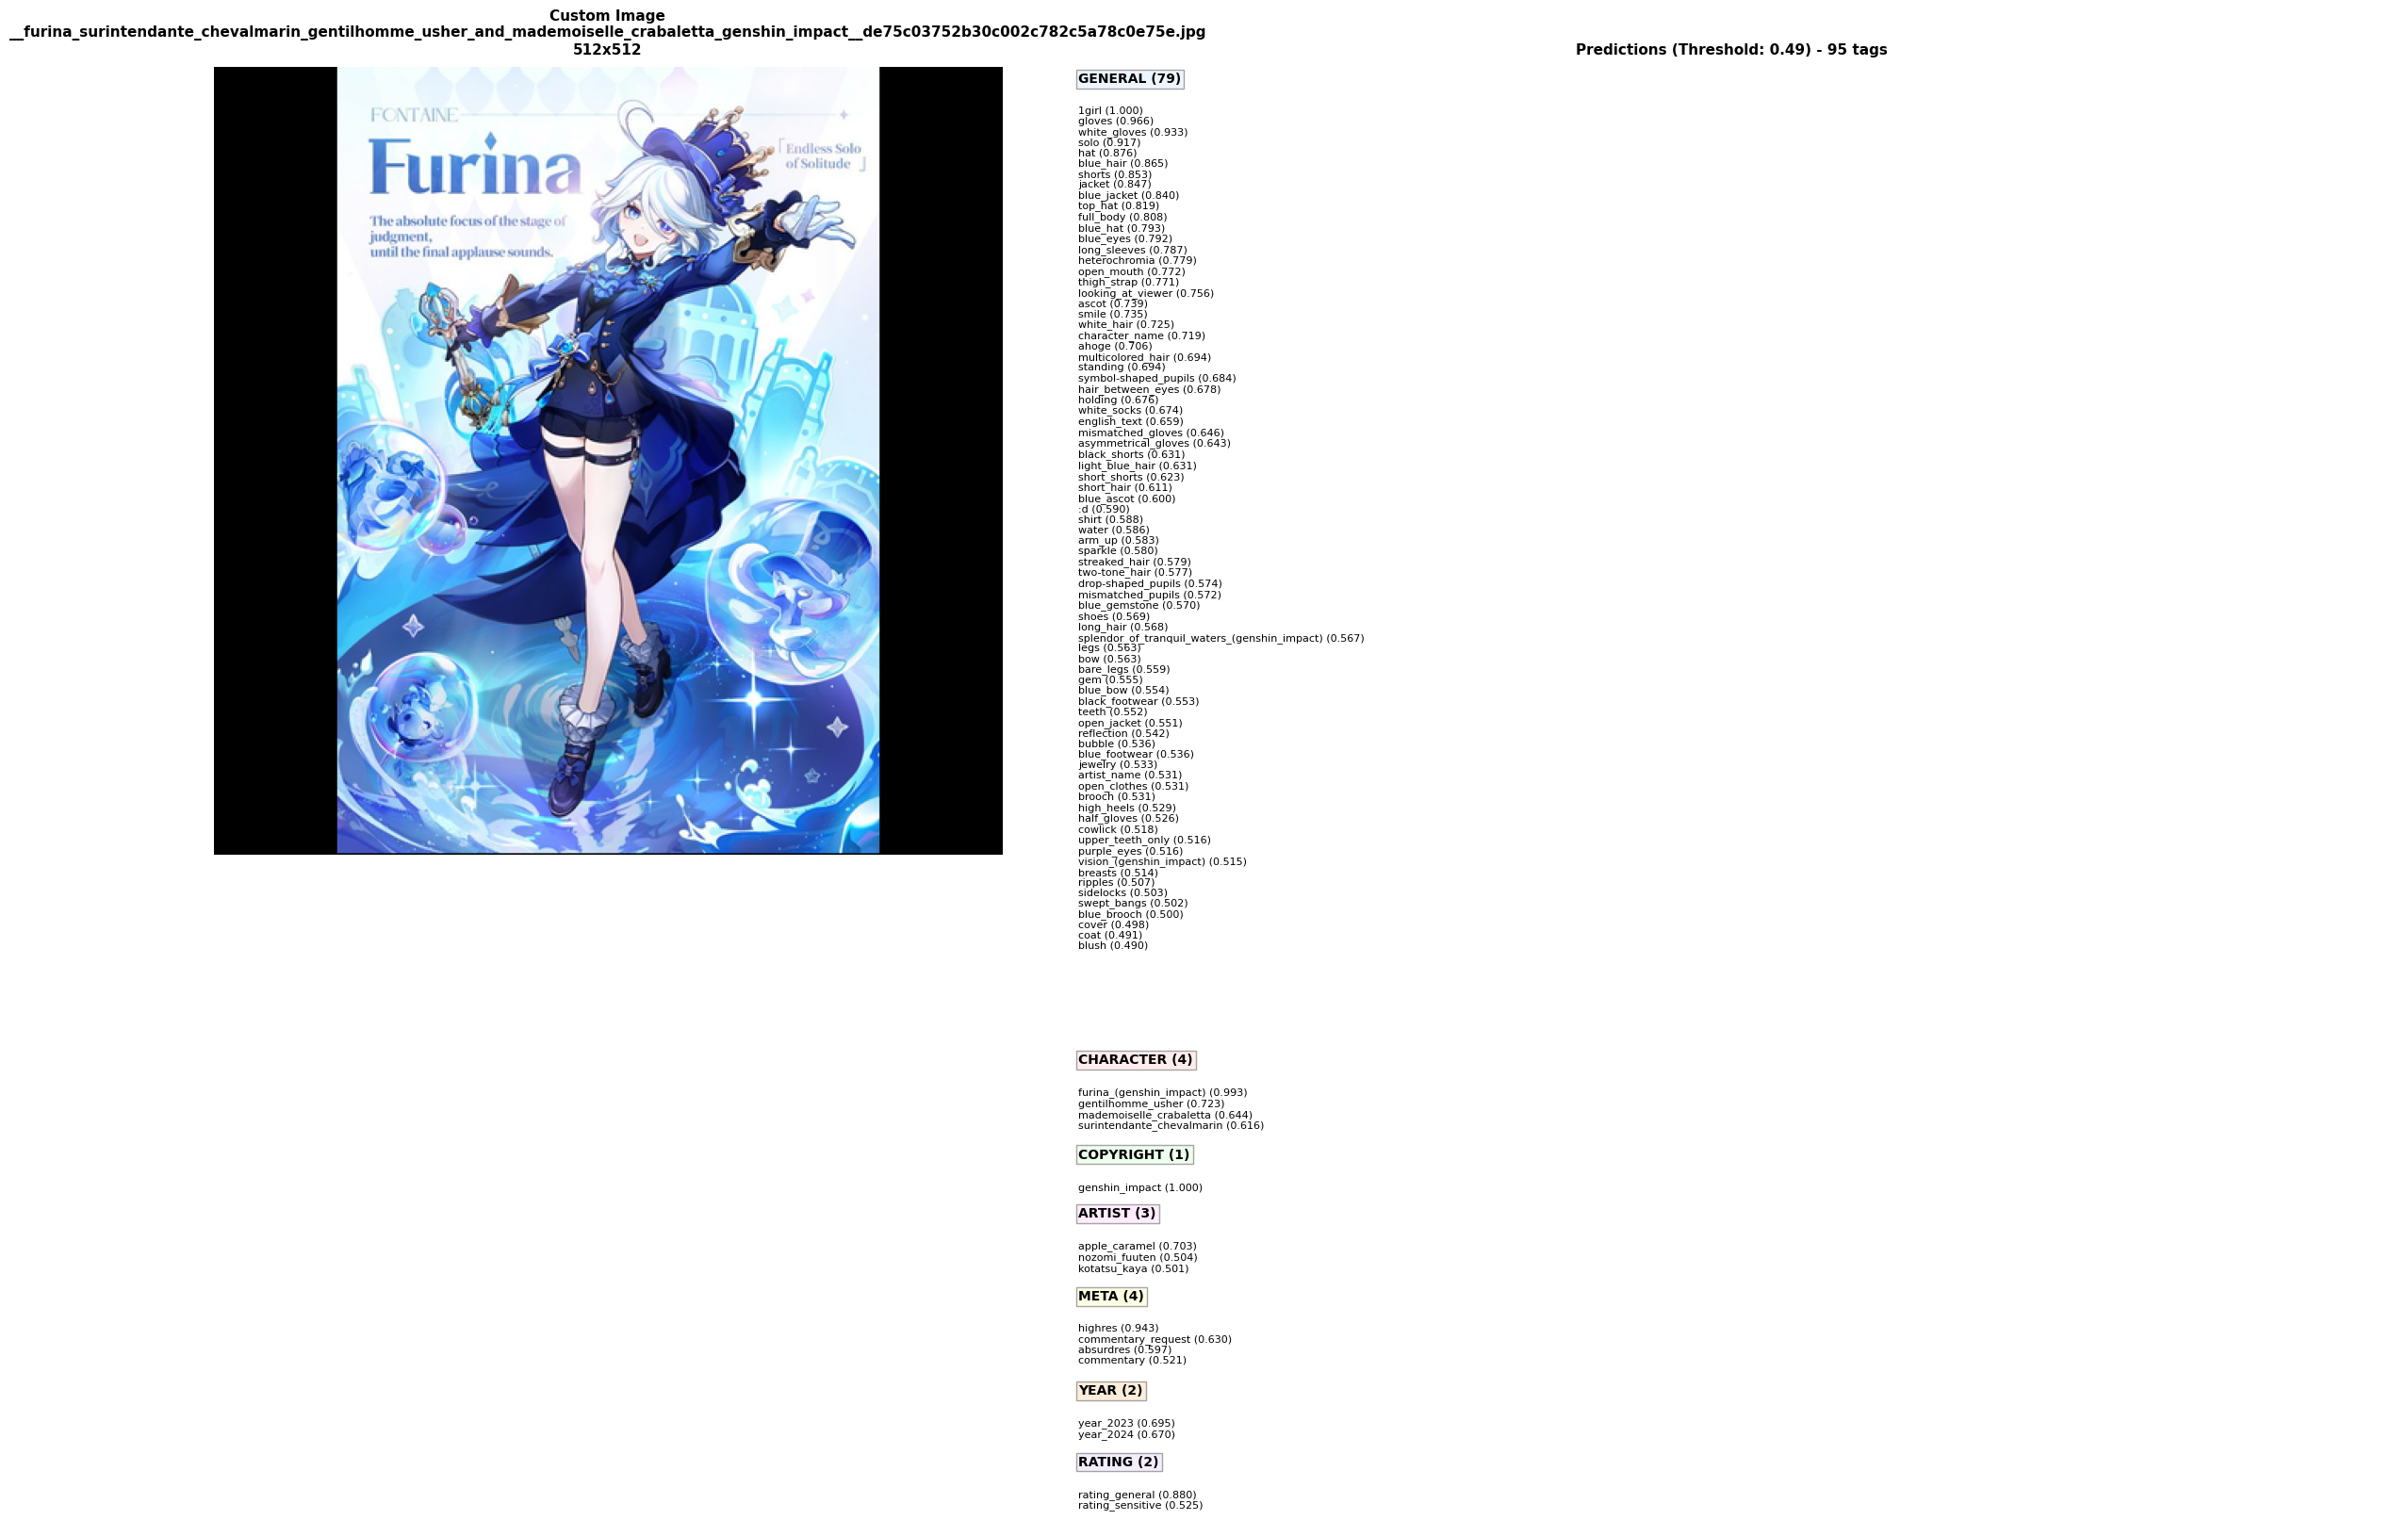


🎯 Prediction Summary:
Image: /mnt/c/Users/Camais/Desktop/AI/Datasets/Anime Images/Test Images/__furina_surintendante_chevalmarin_gentilhomme_usher_and_mademoiselle_crabaletta_genshin_impact__de75c03752b30c002c782c5a78c0e75e.jpg
Total predictions (>0.49): 95
Max confidence: 1.000
Average confidence: 0.652


In [ ]:
predict_custom_image(model, dataset, '.jpg', threshold=0.49)

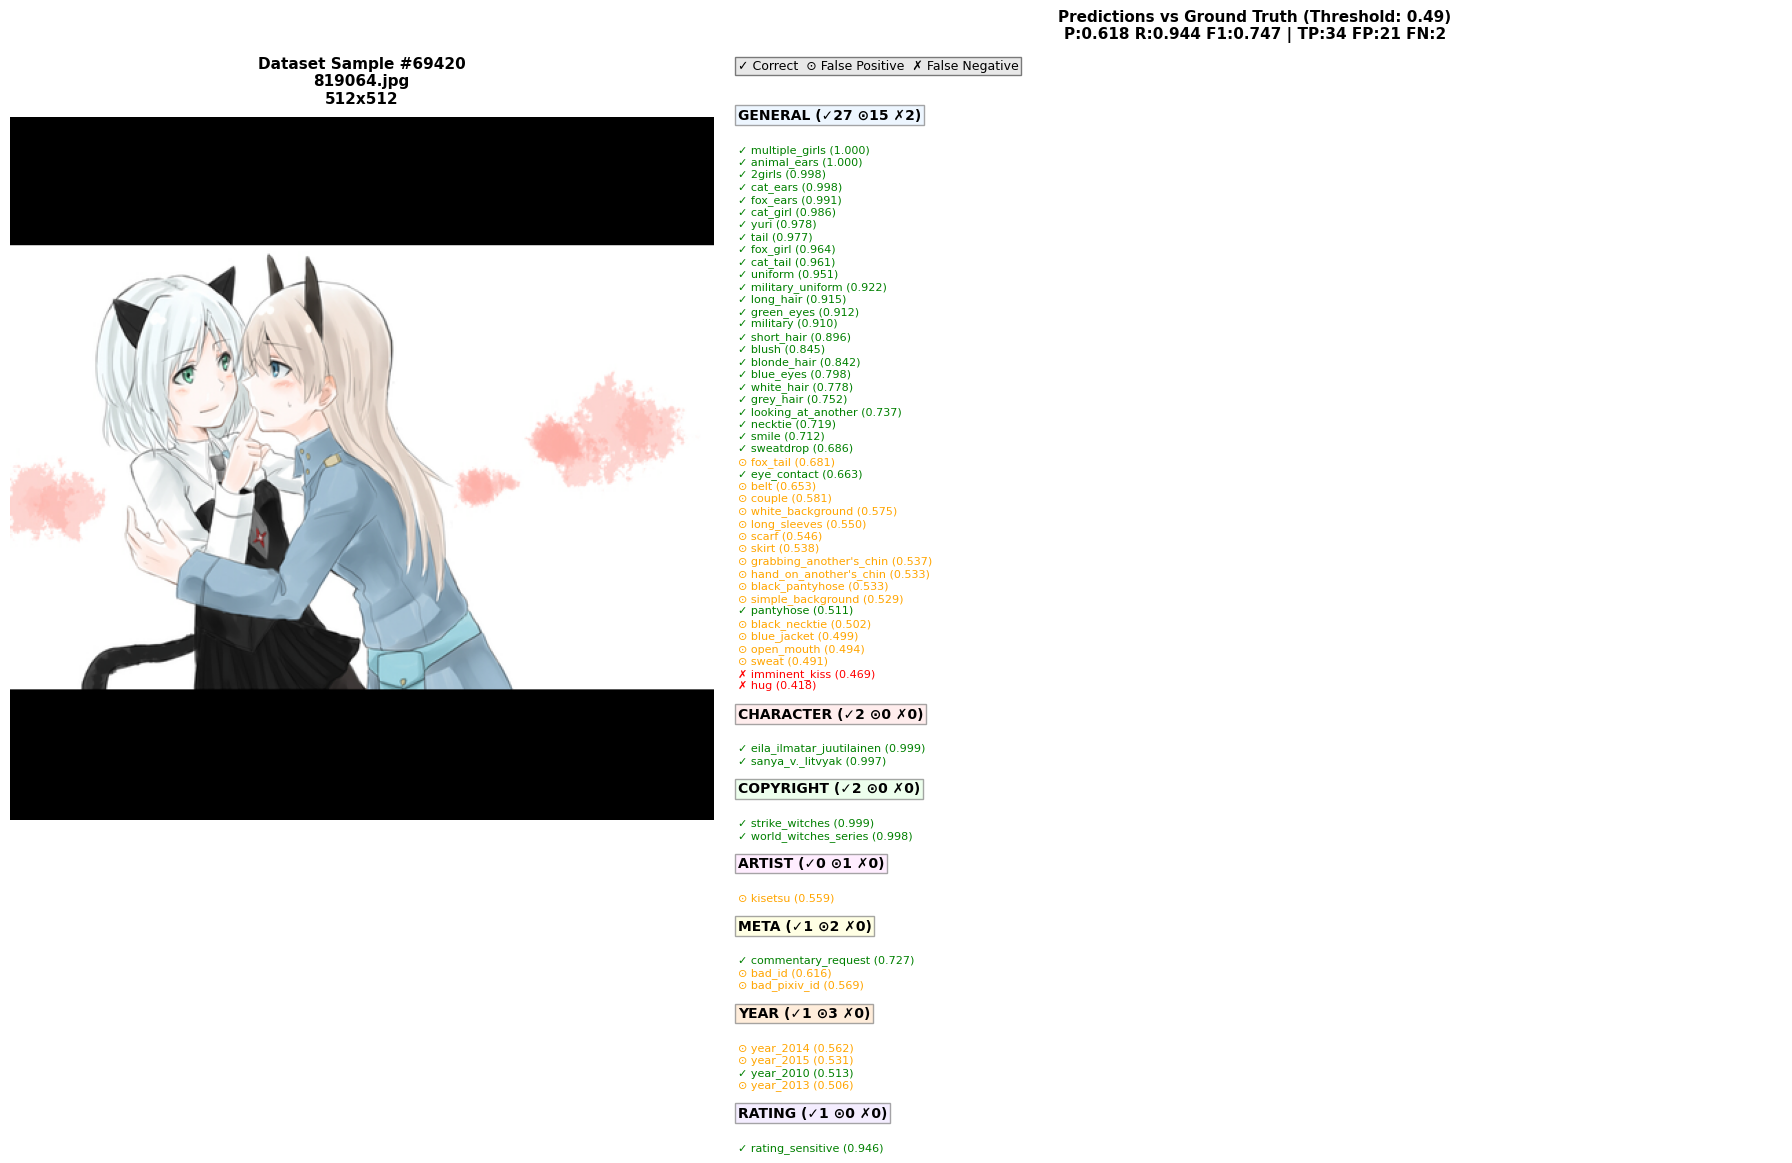


🎯 Prediction Analysis for Sample 69420:
Ground Truth: 36 tags
Predictions: 55 tags (threshold >0.49)
True Positives: 34
False Positives: 21
False Negatives: 2
Precision: 0.618
Recall: 0.944
F1-Score: 0.747

Top False Positives:
  fox_tail (0.681)
  belt (0.653)
  bad_id (0.616)
  couple (0.581)
  white_background (0.575)

Top False Negatives:
  imminent_kiss (0.469)
  hug (0.418)


In [15]:
predict_dataset_image(model, dataset, idx=69420, threshold=0.49)

## ONNX Conversion:

In [ ]:
import torch
import torch.nn as nn
from safetensors.torch import save_file
import onnx
from pathlib import Path
import json
import warnings
from typing import Dict, Any, Optional, Tuple
from collections import OrderedDict

def convert_imagetagger_to_formats(
    checkpoint_path: str,
    output_dir: str,
    model_name: str = "imagetagger_model",
    img_size: int = 512,
    batch_size: int = 1,
    device: str = 'cuda',
    include_safetensors: bool = True,
    include_onnx: bool = True,
    onnx_opset_version: int = 17,
    simplify_onnx: bool = True
) -> Dict[str, str]:
    """
    Convert ImageTagger model from checkpoint to SafeTensors and/or ONNX formats.
    
    Args:
        checkpoint_path: Path to the PyTorch checkpoint file
        output_dir: Directory to save converted models
        model_name: Base name for output files
        img_size: Input image size (assumed square)
        batch_size: Batch size for ONNX export (use 1 for dynamic batching)
        device: Device to load model on ('cuda' or 'cpu')
        include_safetensors: Whether to export SafeTensors format
        include_onnx: Whether to export ONNX format
        onnx_opset_version: ONNX opset version to use
        simplify_onnx: Whether to simplify the ONNX model
        
    Returns:
        Dictionary with paths to created files
    """
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    created_files = {}
    
    print(f"🔄 Converting ImageTagger model from {checkpoint_path}")
    print(f"📁 Output directory: {output_dir}")
    
    # Load the model
    print("📦 Loading model...")
    model, dataset_info, config = load_trained_model_for_export(checkpoint_path, device)
    
    # Save metadata
    print("💾 Saving model metadata...")
    metadata_path = output_dir / f"{model_name}_metadata.json"
    metadata = create_model_metadata(model, dataset_info, config, img_size)
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    created_files['metadata'] = str(metadata_path)
    
    # Convert to SafeTensors
    if include_safetensors:
        print("🛡️ Converting to SafeTensors format...")
        safetensors_path = convert_to_safetensors(
            model, output_dir / f"{model_name}.safetensors", metadata
        )
        created_files['safetensors'] = str(safetensors_path)
    
    # Convert to ONNX
    if include_onnx:
        print("🔄 Converting to ONNX format...")
        onnx_path = convert_to_onnx(
            model, output_dir / f"{model_name}.onnx", 
            img_size, batch_size, onnx_opset_version, simplify_onnx, device
        )
        created_files['onnx'] = str(onnx_path)
    
    print("✅ Conversion complete!")
    print("📋 Created files:")
    for file_type, path in created_files.items():
        print(f"   {file_type}: {path}")
    
    return created_files

def load_trained_model_for_export(checkpoint_path: str, device: str = 'cuda'):
    """
    Load trained model specifically for export (disabling training-specific features)
    """
    print(f"   Loading checkpoint: {checkpoint_path}")
    
    if not Path(checkpoint_path).exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']
    dataset_info = checkpoint['dataset_config']
    
    # Create model with export-friendly settings
    model = ImageTagger(
        total_tags=dataset_info['total_tags'],
        dataset=None,
        model_name=getattr(config, 'feature_extractor', 'vit_base_patch16_384'),
        num_heads=getattr(config, 'vit_heads', 16),
        dropout=0.0,  # Disable dropout for export
        pretrained=False,
        tag_context_size=getattr(config, 'token_dim', 256),
        use_gradient_checkpointing=False,  # Disable checkpointing for export
        img_size=getattr(config, 'img_size', 512)
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Disable any debugging/stats features
    model._flags['debug'] = False
    model._flags['model_stats'] = False
    
    print(f"   ✅ Model loaded with {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
    
    return model, dataset_info, config

def create_model_metadata(model, dataset_info: Dict, config: Any, img_size: int) -> Dict[str, Any]:
    """Create comprehensive metadata for the exported model"""
    
    # Count parameters by component
    total_params = sum(p.numel() for p in model.parameters())
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    
    metadata = {
        "model_info": {
            "architecture": "ImageTagger with Vision Transformer",
            "backbone": getattr(config, 'feature_extractor', 'vit_base_patch16_384'),
            "img_size": img_size,
            "total_parameters": total_params,
            "backbone_parameters": backbone_params,
            "embedding_dim": model.embedding_dim,
            "patch_size": model.backbone.patch_size,
            "feature_map_size": model.feature_map_size,
            "num_attention_heads": getattr(config, 'vit_heads', 16),
            "tag_context_size": model.tag_context_size
        },
        "dataset_info": {
            "total_tags": dataset_info['total_tags'],
            "categories": list(set(dataset_info['tag_to_category'].values())),
            "tag_mapping": {
                "tag_to_idx": dataset_info['tag_to_idx'],
                "idx_to_tag": dataset_info['idx_to_tag'], 
                "tag_to_category": dataset_info['tag_to_category']
            }
        },
        "input_spec": {
            "format": "RGB image tensor",
            "shape": [3, img_size, img_size],
            "dtype": "float32",
            "normalization": "ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])",
            "value_range": "Normalized to ImageNet statistics"
        },
        "output_spec": {
            "initial_predictions": {
                "shape": ["batch_size", dataset_info['total_tags']],
                "dtype": "float32",
                "description": "Initial tag predictions from global features"
            },
            "refined_predictions": {
                "shape": ["batch_size", dataset_info['total_tags']],
                "dtype": "float32", 
                "description": "Refined predictions after cross-attention"
            },
            "selected_candidates": {
                "shape": ["batch_size", model.tag_context_size],
                "dtype": "int64",
                "description": "Indices of selected candidate tags"
            }
        },
        "usage": {
            "threshold_recommendation": "Use sigmoid activation and threshold around 0.5",
            "preprocessing": "Apply ImageNet normalization",
            "postprocessing": "Apply sigmoid to get probabilities"
        },
        "export_info": {
            "pytorch_version": torch.__version__,
            "safetensors_compatible": True,
            "onnx_compatible": True
        }
    }
    
    return metadata

def convert_to_safetensors(model: nn.Module, output_path: Path, metadata: Dict) -> Path:
    """Convert model to SafeTensors format with metadata"""
    
    # Get model state dict
    state_dict = model.state_dict()
    
    # Convert any non-tensor values and ensure proper dtypes
    clean_state_dict = {}
    for key, value in state_dict.items():
        if isinstance(value, torch.Tensor):
            # Ensure tensor is on CPU and in a standard dtype
            if value.dtype in [torch.float16, torch.bfloat16]:
                value = value.float()
            clean_state_dict[key] = value.cpu()
        else:
            print(f"   ⚠️ Skipping non-tensor parameter: {key}")
    
    # Create SafeTensors metadata (must be strings)
    safetensors_metadata = {
        "model_type": "ImageTagger",
        "architecture": str(metadata["model_info"]["architecture"]),
        "backbone": str(metadata["model_info"]["backbone"]),
        "total_tags": str(metadata["dataset_info"]["total_tags"]),
        "img_size": str(metadata["model_info"]["img_size"]),
        "embedding_dim": str(metadata["model_info"]["embedding_dim"]),
        "total_parameters": str(metadata["model_info"]["total_parameters"]),
        "pytorch_version": torch.__version__
    }
    
    # Save as SafeTensors
    save_file(clean_state_dict, output_path, metadata=safetensors_metadata)
    
    # Verify the saved file
    file_size_mb = output_path.stat().st_size / (1024 * 1024)
    print(f"   ✅ SafeTensors saved: {output_path} ({file_size_mb:.1f} MB)")
    
    return output_path

def convert_to_onnx(
    model: nn.Module, 
    output_path: Path, 
    img_size: int, 
    batch_size: int,
    opset_version: int = 17,
    simplify: bool = True,
    device: str = 'cuda'
) -> Path:
    """Convert model to ONNX format"""
    
    # Create wrapper for ONNX export (flatten dictionary output)
    class ONNXImageTagger(nn.Module):
        def __init__(self, original_model):
            super().__init__()
            self.model = original_model
            
        def forward(self, x):
            # Get model outputs
            outputs = self.model(x)
            
            # Return flattened outputs (ONNX doesn't handle dicts well)
            return (
                outputs['initial_predictions'],
                outputs['refined_predictions'], 
                outputs['selected_candidates']
            )
    
    # Wrap the model
    onnx_model = ONNXImageTagger(model).to(device)
    onnx_model.eval()
    
    # Create dummy input
    if batch_size == 1:
        # Dynamic batch dimension
        dummy_input = torch.randn(1, 3, img_size, img_size, device=device, dtype=torch.float32)
        dynamic_axes = {
            'input': {0: 'batch_size'},
            'initial_predictions': {0: 'batch_size'},
            'refined_predictions': {0: 'batch_size'},
            'selected_candidates': {0: 'batch_size'}
        }
    else:
        # Fixed batch dimension
        dummy_input = torch.randn(batch_size, 3, img_size, img_size, device=device, dtype=torch.float32)
        dynamic_axes = None
    
    # Test forward pass
    print("   🧪 Testing forward pass...")
    with torch.no_grad():
        test_output = onnx_model(dummy_input)
        print(f"      Initial preds shape: {test_output[0].shape}")
        print(f"      Refined preds shape: {test_output[1].shape}")  
        print(f"      Candidates shape: {test_output[2].shape}")
    
    # Export to ONNX with error handling
    print(f"   📤 Exporting to ONNX (opset {opset_version})...")
    
    # Suppress warnings for cleaner output
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        
        try:
            torch.onnx.export(
                onnx_model,
                dummy_input,
                output_path,
                export_params=True,
                opset_version=opset_version,
                do_constant_folding=True,
                input_names=['input'],
                output_names=['initial_predictions', 'refined_predictions', 'selected_candidates'],
                dynamic_axes=dynamic_axes,
                verbose=False,
                training=torch.onnx.TrainingMode.EVAL
            )
        except Exception as e:
            print(f"   ❌ ONNX export failed: {e}")
            print("   💡 Trying with reduced opset version...")
            
            # Try with older opset version
            torch.onnx.export(
                onnx_model,
                dummy_input, 
                output_path,
                export_params=True,
                opset_version=11,  # Fallback to older opset
                do_constant_folding=True,
                input_names=['input'],
                output_names=['initial_predictions', 'refined_predictions', 'selected_candidates'],
                dynamic_axes=dynamic_axes,
                verbose=False,
                training=torch.onnx.TrainingMode.EVAL
            )
            print(f"   ✅ ONNX export successful with opset 11")
    
    # Verify ONNX model
    print("   🔍 Verifying ONNX model...")
    try:
        onnx_model_check = onnx.load(str(output_path))
        onnx.checker.check_model(onnx_model_check)
        
        file_size_mb = output_path.stat().st_size / (1024 * 1024)
        print(f"   ✅ ONNX model verified: {output_path} ({file_size_mb:.1f} MB)")
        
        # Print model info
        print(f"      Inputs: {len(onnx_model_check.graph.input)}")
        print(f"      Outputs: {len(onnx_model_check.graph.output)}")
        print(f"      Nodes: {len(onnx_model_check.graph.node)}")
        
    except Exception as e:
        print(f"   ⚠️ ONNX verification failed: {e}")
        print("   Model exported but may have compatibility issues")
    
    # Simplify ONNX model if requested
    if simplify:
        try:
            import onnxsim
            print("   🔧 Simplifying ONNX model...")
            
            simplified_model, check = onnxsim.simplify(str(output_path))
            if check:
                onnx.save(simplified_model, str(output_path))
                simplified_size_mb = output_path.stat().st_size / (1024 * 1024) 
                print(f"   ✅ Model simplified: {simplified_size_mb:.1f} MB")
            else:
                print("   ⚠️ Simplification failed, keeping original")
                
        except ImportError:
            print("   💡 Install onnx-simplifier for model optimization: pip install onnx-simplifier")
        except Exception as e:
            print(f"   ⚠️ Simplification failed: {e}")
    
    return output_path

In [ ]:
checkpoint_path = ""
output_dir = "./exported_models"
    
# Convert model to both formats
created_files = convert_imagetagger_to_formats(
    checkpoint_path=checkpoint_path,
    output_dir=output_dir,
    model_name="camie-tagger-v2", 
    img_size=512,
    batch_size=1,  # Use 1 for dynamic batching
    include_safetensors=True,
    include_onnx=True,
    simplify_onnx=True
)

print("\n🎉 Conversion completed!")
print("Files created:")
for file_type, path in created_files.items():
    print(f"  {file_type}: {path}")

In [22]:
def preprocess_image(image_path, image_size=512):
    """
    Process an image for ImageTagger inference with proper ImageNet normalization
    """
    import torchvision.transforms as transforms
    from PIL import Image
    import os
    
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found at path: {image_path}")
    
    # ImageNet normalization - CRITICAL for your model
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    try:
        with Image.open(image_path) as img:
            # Convert RGBA or Palette images to RGB
            if img.mode in ('RGBA', 'P'):
                img = img.convert('RGB')
            
            # Get original dimensions
            width, height = img.size
            aspect_ratio = width / height
            
            # Calculate new dimensions to maintain aspect ratio
            if aspect_ratio > 1:
                new_width = image_size
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = image_size
                new_width = int(new_height * aspect_ratio)
            
            # Resize with LANCZOS filter
            img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            
            # Create new image with padding (use ImageNet mean for padding)
            # Using RGB values close to ImageNet mean: (0.485*255, 0.456*255, 0.406*255)
            pad_color = (124, 116, 104)
            new_image = Image.new('RGB', (image_size, image_size), pad_color)
            paste_x = (image_size - new_width) // 2
            paste_y = (image_size - new_height) // 2
            new_image.paste(img, (paste_x, paste_y))
            
            # Apply transforms (including ImageNet normalization)
            img_tensor = transform(new_image)
            return img_tensor
            
    except Exception as e:
        raise Exception(f"Error processing {image_path}: {str(e)}")

def test_onnx_imagetagger(model_path, metadata_path, image_path, threshold=0.5, top_k=256):
    """
    Test ImageTagger ONNX model with proper handling of all outputs
    
    Args:
        model_path: Path to ONNX model file
        metadata_path: Path to metadata JSON file  
        image_path: Path to test image
        threshold: Confidence threshold for predictions
        top_k: Maximum number of predictions to show
    """
    import onnxruntime as ort
    import numpy as np
    import json
    import time
    from collections import defaultdict
    
    print(f"Loading ImageTagger ONNX model from {model_path}")
    
    # Load metadata with proper error handling
    try:
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
    except Exception as e:
        raise ValueError(f"Failed to load metadata: {e}")
    
    # Extract tag mappings from nested structure
    try:
        dataset_info = metadata['dataset_info']
        tag_mapping = dataset_info['tag_mapping']
        idx_to_tag = tag_mapping['idx_to_tag']
        tag_to_category = tag_mapping['tag_to_category']
        total_tags = dataset_info['total_tags']
        
        print(f"Model info: {total_tags} tags, {len(set(tag_to_category.values()))} categories")
        
    except KeyError as e:
        raise ValueError(f"Invalid metadata structure, missing key: {e}")
    
    # Initialize ONNX session with robust provider handling
    providers = []
    if ort.get_device() == 'GPU':
        providers.append('CUDAExecutionProvider')
    providers.append('CPUExecutionProvider')
    
    try:
        session = ort.InferenceSession(model_path, providers=providers)
        active_provider = session.get_providers()[0]
        print(f"Using provider: {active_provider}")
        
        # Print model info
        inputs = session.get_inputs()
        outputs = session.get_outputs()
        print(f"Model inputs: {len(inputs)}")
        print(f"Model outputs: {len(outputs)}")
        for i, output in enumerate(outputs):
            print(f"  Output {i}: {output.name} {output.shape}")
            
    except Exception as e:
        raise RuntimeError(f"Failed to create ONNX session: {e}")
    
    # Preprocess image
    print(f"Processing image: {image_path}")
    try:
        img_tensor = preprocess_image(image_path, image_size=metadata['model_info']['img_size'])
        img_numpy = img_tensor.unsqueeze(0).numpy()  # Add batch dimension
        print(f"Input shape: {img_numpy.shape}, dtype: {img_numpy.dtype}")
        
    except Exception as e:
        raise ValueError(f"Image preprocessing failed: {e}")
    
    # Run inference
    input_name = session.get_inputs()[0].name
    print("Running inference...")
    
    start_time = time.time()
    try:
        outputs = session.run(None, {input_name: img_numpy})
        inference_time = time.time() - start_time
        print(f"Inference completed in {inference_time:.4f} seconds")
        
    except Exception as e:
        raise RuntimeError(f"Inference failed: {e}")
    
    # Handle outputs properly
    # outputs[0] = initial_predictions, outputs[1] = refined_predictions, outputs[2] = selected_candidates
    if len(outputs) >= 2:
        initial_logits = outputs[0]
        refined_logits = outputs[1] 
        selected_candidates = outputs[2] if len(outputs) > 2 else None
        
        # Use refined predictions as main output
        main_logits = refined_logits
        print(f"Using refined predictions (shape: {refined_logits.shape})")
        
    else:
        # Fallback to single output
        main_logits = outputs[0]
        print(f"Using single output (shape: {main_logits.shape})")
    
    # Apply sigmoid to get probabilities
    main_probs = 1.0 / (1.0 + np.exp(-main_logits))
    
    # Apply threshold and get predictions
    predictions_mask = (main_probs >= threshold)
    indices = np.where(predictions_mask[0])[0]
    
    if len(indices) == 0:
        print(f"No predictions above threshold {threshold}")
        # Show top 5 regardless of threshold
        top_indices = np.argsort(main_probs[0])[-5:][::-1]
        print("Top 5 predictions:")
        for idx in top_indices:
            idx_str = str(idx)
            tag_name = idx_to_tag.get(idx_str, f"unknown-{idx}")
            prob = float(main_probs[0, idx])
            print(f"  {tag_name}: {prob:.3f}")
        return {}
    
    # Group by category  
    tags_by_category = defaultdict(list)
    
    for idx in indices:
        idx_str = str(idx)
        tag_name = idx_to_tag.get(idx_str, f"unknown-{idx}")
        category = tag_to_category.get(tag_name, "general")
        prob = float(main_probs[0, idx])
        
        tags_by_category[category].append((tag_name, prob))
    
    # Sort by probability within each category
    for category in tags_by_category:
        tags_by_category[category] = sorted(
            tags_by_category[category], 
            key=lambda x: x[1], 
            reverse=True
        )[:top_k]  # Limit per category
    
    # Print results
    total_predictions = sum(len(tags) for tags in tags_by_category.values())
    print(f"\nPredicted tags (threshold: {threshold}): {total_predictions} total")
    
    # Category order for consistent display
    category_order = ['general', 'character', 'copyright', 'artist', 'meta', 'year', 'rating']
    
    for category in category_order:
        if category in tags_by_category:
            tags = tags_by_category[category]
            print(f"\n{category.upper()} ({len(tags)}):")
            for tag, prob in tags:
                print(f"  {tag}: {prob:.3f}")
    
    # Show any other categories not in standard order
    for category in sorted(tags_by_category.keys()):
        if category not in category_order:
            tags = tags_by_category[category]
            print(f"\n{category.upper()} ({len(tags)}):")
            for tag, prob in tags:
                print(f"  {tag}: {prob:.3f}")
    
    # Performance stats
    print(f"\nPerformance:")
    print(f"  Inference time: {inference_time:.4f}s")
    print(f"  Provider: {active_provider}")
    print(f"  Max confidence: {main_probs.max():.3f}")
    if total_predictions > 0:
        avg_conf = np.mean([prob for tags in tags_by_category.values() for _, prob in tags])
        print(f"  Average confidence: {avg_conf:.3f}")
    
    return dict(tags_by_category)

In [ ]:
test_image = ".jpg"  

results = test_onnx_imagetagger(
    created_files['onnx'],
    created_files['metadata'], 
    test_image,
    threshold=0.49
)